# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame sampling | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,1408] | 0.09|
 


CASE 1
flow -> [batch_video,nr_windows=8,(8,14,14,768)] => 
    => spatial mean reduction =>
    =>[batch_video,nr_windows=8,(8,1,1,768)] => 
    => RESHAPE =>
    => [batch_video,nr_windows=8,(8*1*1*768)] =>
    => 2 GRU((6144,512)|dropout(0.5)|(512,512)) + linear proj (512,1) =>
    => [batch_video,1]

CASE 2
flow -> [batch_video,nr_windows=8,(8,14,14,768)] => 
    => spatial mean reduction =>
    =>[batch_video,nr_windows=8,(8,1,1,768)] => 
    => RESHAPE =>
    => [batch_video,nr_windows=8*8,(1*1*768)] =>
    => 2 GRU((768,512)|drop_out(0.3)|(512,512)) + linear proj (512,1) =>
    => [batch_video,1]
    


# Code (w/ lib) 

Add sanity check when init to see if folders and custom methods are created

Kernel: RBF that can handle non-linear pattern
C: Low to avoid overfit
eps:  high values lead to a simpler model but potentially less precise predictions
      low values require tighter predictions, which can make the model more complex

WHAT I HAVE:

CLIPS_REDUCTION values:
  MEAN: 0 (applied in action recognition)
  GRU: lstm (work in progress)

EMBEDDING_REDUCTION values:
  MEAN_TEMPORAL: 1      [keep spatial information]
  MEAN_SPATIAL: (2, 3)  [keep temporal information]
  MEAN_TEMPORAL_SPATIAL: (1, 2, 3) [applied in action recognition]
  GRU: GRU (work in progress)

MODEL_TYPE values:
  VIDEOMAE_v2_S: smaller model
  VIDEOMAE_v2_B: base model
  VIDEOMAE_v2_G_pt_1200e: giant model w/h intermediate fine-tuning
  VIDEOMAE_v2_G_pt_1200e_K710_it_HMDB51_ft: giant model fine-tuned

SAMPLE_FRAME_STRATEGY values:
  UNIFORM: uniform
  SLIDING_WINDOW: sliding_window
  CENTRAL_SAMPLING: central_sampling
  RANDOM_SAMPLING: random_sampling

HEAD
  SVR
____________________________________________________________________________


TESTING SETTINGS GRID_SEARCH
model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_TEMPORAL_SPATIAL
clips_reduction = CLIPS_REDUCTION.MEAN
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.UNIFORM

path_labels = os.path.join('partA','starting_point','subsamples_100_400.csv') # 110 samples per class, 400 samples in total
path_dataset = os.path.join('partA','video','video')
k_cross validation = 5 (Stratified K-Fold cross-validator-> The folds are made by preserving the percentage of samples for each class.)

grid_search = {
  'kernel': ['rbf'],
  'C': [0.1, 1, 10],
  'epsilon': [0.1, 1, 10, 100],
}

Form table we have:
  best_estimator ={
    kernel:'rbf',
    'C': [0.1, 1, 10]
    'epsilon':[10, 100]
  }

<div style="overflow-x: auto;">

In [3]:
from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY, HEAD
import os
from custom.model import Model_Advanced
from transformers import AutoImageProcessor
from custom.head import HeadSVR, HeadGRU
import time

In [8]:
%load_ext autoreload
%autoreload 2

model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL
# clips_reduction = CLIPS_REDUCTION.MEAN
# embedding_reduction = None
clips_reduction = CLIPS_REDUCTION.NONE
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW

# path_labels = os.path.join('partA','starting_point','samples.csv')
# 'original' : os.path.join('partA','starting_point','subsamples_60_240.csv'),
# path_dict ={
  
#   'train' : os.path.join('partA','starting_point','train_191.csv'),
#   'val' : os.path.join('partA','starting_point','val_26.csv'),
#   'test' : os.path.join('partA','starting_point','test_23.csv')
# }
path_dict ={
  'all' : os.path.join('partA','starting_point','train_191.csv'),
  'train' : os.path.join('partA','starting_point','train_21.csv'),
  'val' : os.path.join('partA','starting_point','val_26'),
  'test' : os.path.join('partA','starting_point','test_5.csv')
}

path_dataset = os.path.join('partA','video','video')  
# head = HeadSVR(svr_params={'kernel':'rbf','C':1,'epsilon':10})
head = 'GRU'
if head == 'GRU':
  params = {
    'hidden_size': 512,
    'num_layers': 1,
    'dropout': 0.0
  }
else: 
  params ={
    'kernel':'rbf',
    'C':1,
    'epsilon':10
  }
# print(f'\npath_labels: {path_labels}\n')

preprocess = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")

model_advanced = Model_Advanced(model_type=model_type,
                                path_dataset=path_dataset,
                                embedding_reduction=embedding_reduction,
                                clips_reduction=clips_reduction,
                                sample_frame_strategy=sample_frame_strategy,
                                stride_window=70,
                                path_labels=path_dict['all'],
                                preprocess=preprocess,
                                batch_size=1,
                                head=head,
                                head_params=params,
                                download_if_unavailable=True
                                ) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
head_params : {'hidden_size': 512, 'num_layers': 1, 'dropout': 0.0, 'input_size': 6144}
output_tensor : [1, 8, 1, 1, 768]


In [13]:
tens.sum(1)

tensor([5, 1, 0, 2, 0])

{'accuracy_per_class': tensor([   nan, 0.6667, 1.0000, 0.0000,    nan]),
 'mean_accuracy': tensor(0.5556),
 'mean_weighted_accuracy': tensor(0.2727)}

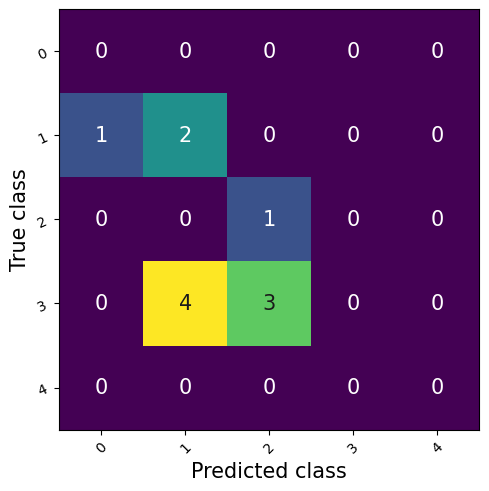

In [15]:
from torchmetrics.classification import ConfusionMatrix
import torch
import custom.tools as tools

confusion_matrix = ConfusionMatrix(task='multiclass',num_classes=5)
pred__ = torch.tensor([0,1,1,2,1,2,2,1,1,2,1])
target = torch.tensor([1,3,3,2,1,3,3,3,3,3,1])
confusion_matrix.update(pred__, target)
tens=confusion_matrix.compute()
confusion_matrix.plot()
tools.get_accuracy_from_confusion_matrix(tens)

In [6]:
import numpy as np
np.unique([0,1,2,3]).shape[0]

4

In [12]:
import torch

tensor = torch.arange(10).unsqueeze(1).repeat(1, 8).T
idx = [3,2,4,1,2,3,4,3]
print(tensor[torch.arange(tensor.size(0)), idx])

tensor([3, 2, 4, 1, 2, 3, 4, 3])


In [4]:
import torch.nn as nn
import torch.optim as optim
import torch
# Instantiate the L1Loss
loss_fn = nn.L1Loss()
optimize = torch.optim.Adam
print(optimize.__name__)
# Print the name of the loss function
print(type(loss_fn).__name__)


Adam
L1Loss


In [1]:
import torch
torch.cuda.is_available()

True

In [52]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

numDataPoints = 1000
data_dim = 5
bs = 100

# Create dummy data with class imbalance 9 to 1
data = torch.FloatTensor(numDataPoints, data_dim)
target = np.hstack((np.zeros(int(numDataPoints * 0.9), dtype=np.int32),
                    np.ones(int(numDataPoints * 0.1), dtype=np.int32)))

print ('target train 0/1: {}/{}'.format(
    len(np.where(target == 0)[0]), len(np.where(target == 1)[0])))

class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])
print(samples_weight)

# samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

target = torch.from_numpy(target).long()
train_dataset = torch.utils.data.TensorDataset(data, target)

train_loader = DataLoader(
    train_dataset, batch_size=bs, num_workers=1, sampler=sampler)

for i, (data, target) in enumerate(train_loader):
    print("batch index {}, 0/1: {}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0])))

target train 0/1: 900/100
[0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111 0.00111111
 0.00111111 0.00111111 0.00111111 0.

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

Start training phase the model at history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733933077
Generating train, test and validation csv files
nr_train_samples: 18
nr_test_samples: 2
nr_val_samples: 3
train csv split saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733933077/train_GRU/train.csv
val csv split saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733933077/train_GRU/val.csv
test csv split saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733933077/train_GRU/test.csv
Split indices saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733933077/train_GRU/split_indices.json
Plotting train,test,val distribution
Training model
training using validation set
Extracting features...
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733933077/train_GRU/train.csv
Loading features from SSD...
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/torchmetrics/utilities/plot.py:269: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=rows, ncols=cols, constrained_layout=True) if ax is None else (ax.get_figure(), ax)


Plot precision_per_class over Epochs  saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733933077/train_GRU/confusion_matricies/plot_over_epochs/precision_per_class.png.png
Plot recall_per_class over Epochs  saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733933077/train_GRU/confusion_matricies/plot_over_epochs/recall_per_class.png.png
Plot macro_precision over Epochs  saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733933077/train_GRU/confusion_matricies/plot_over_epochs/macro_precision.png.png
Plot macro_recall over Epochs  saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733933077/train_GRU/confusion_matricies/plot_over_epochs/macro_recall.png.png
Plot micro_precision over Epochs  saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733933077/train_GRU/confusion_matricies/plot_over_epochs/micro_precision.png.png
Plot micro_recall over Epochs  saved to history_run/VIDE

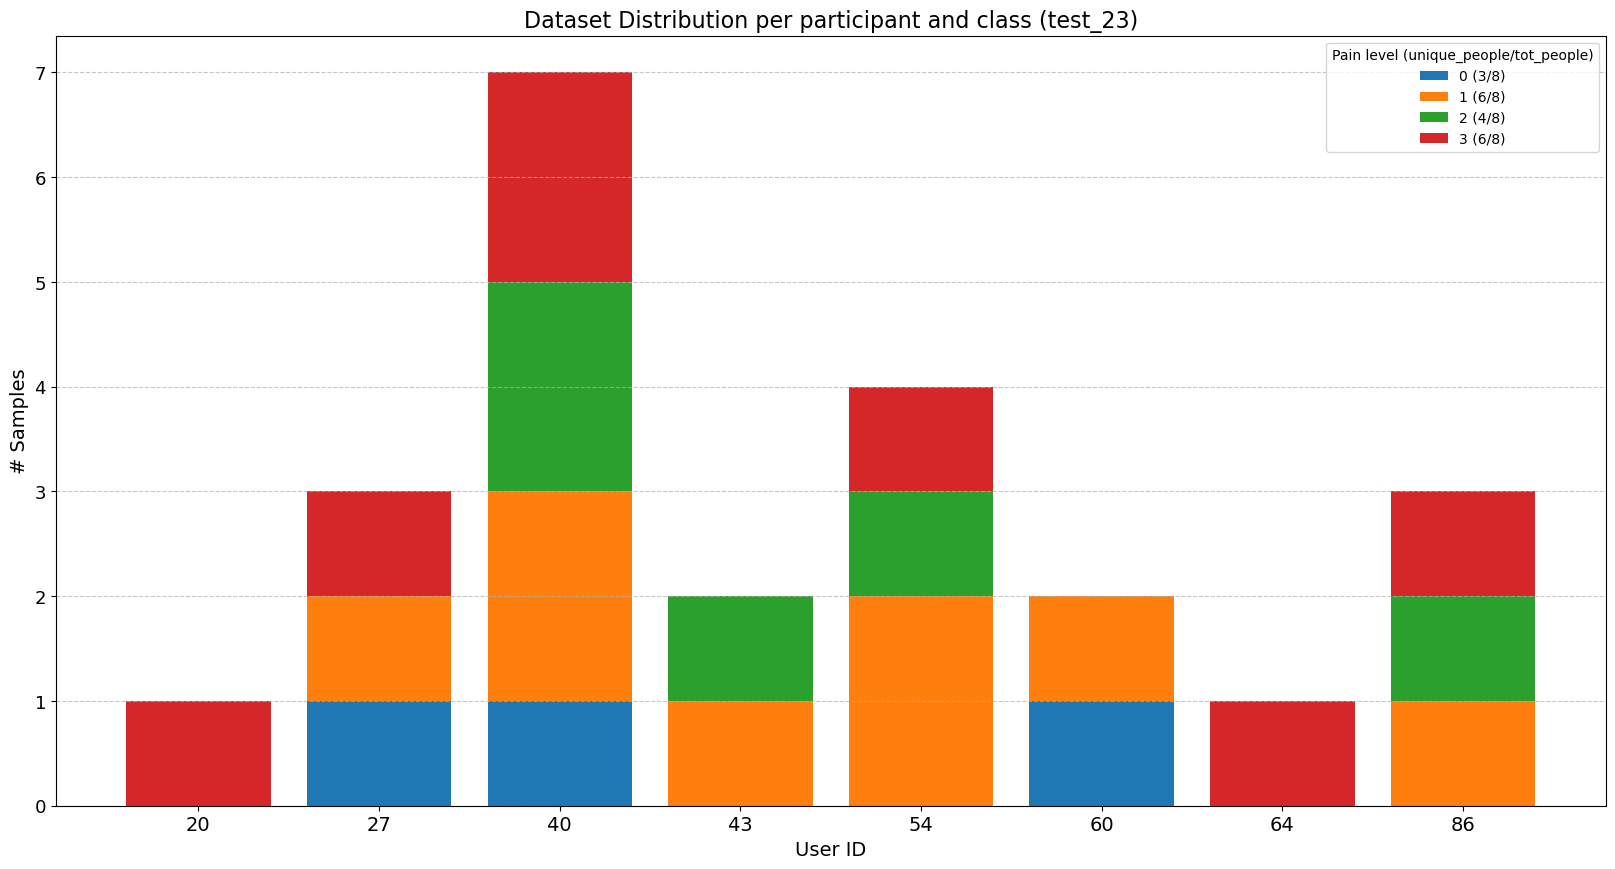

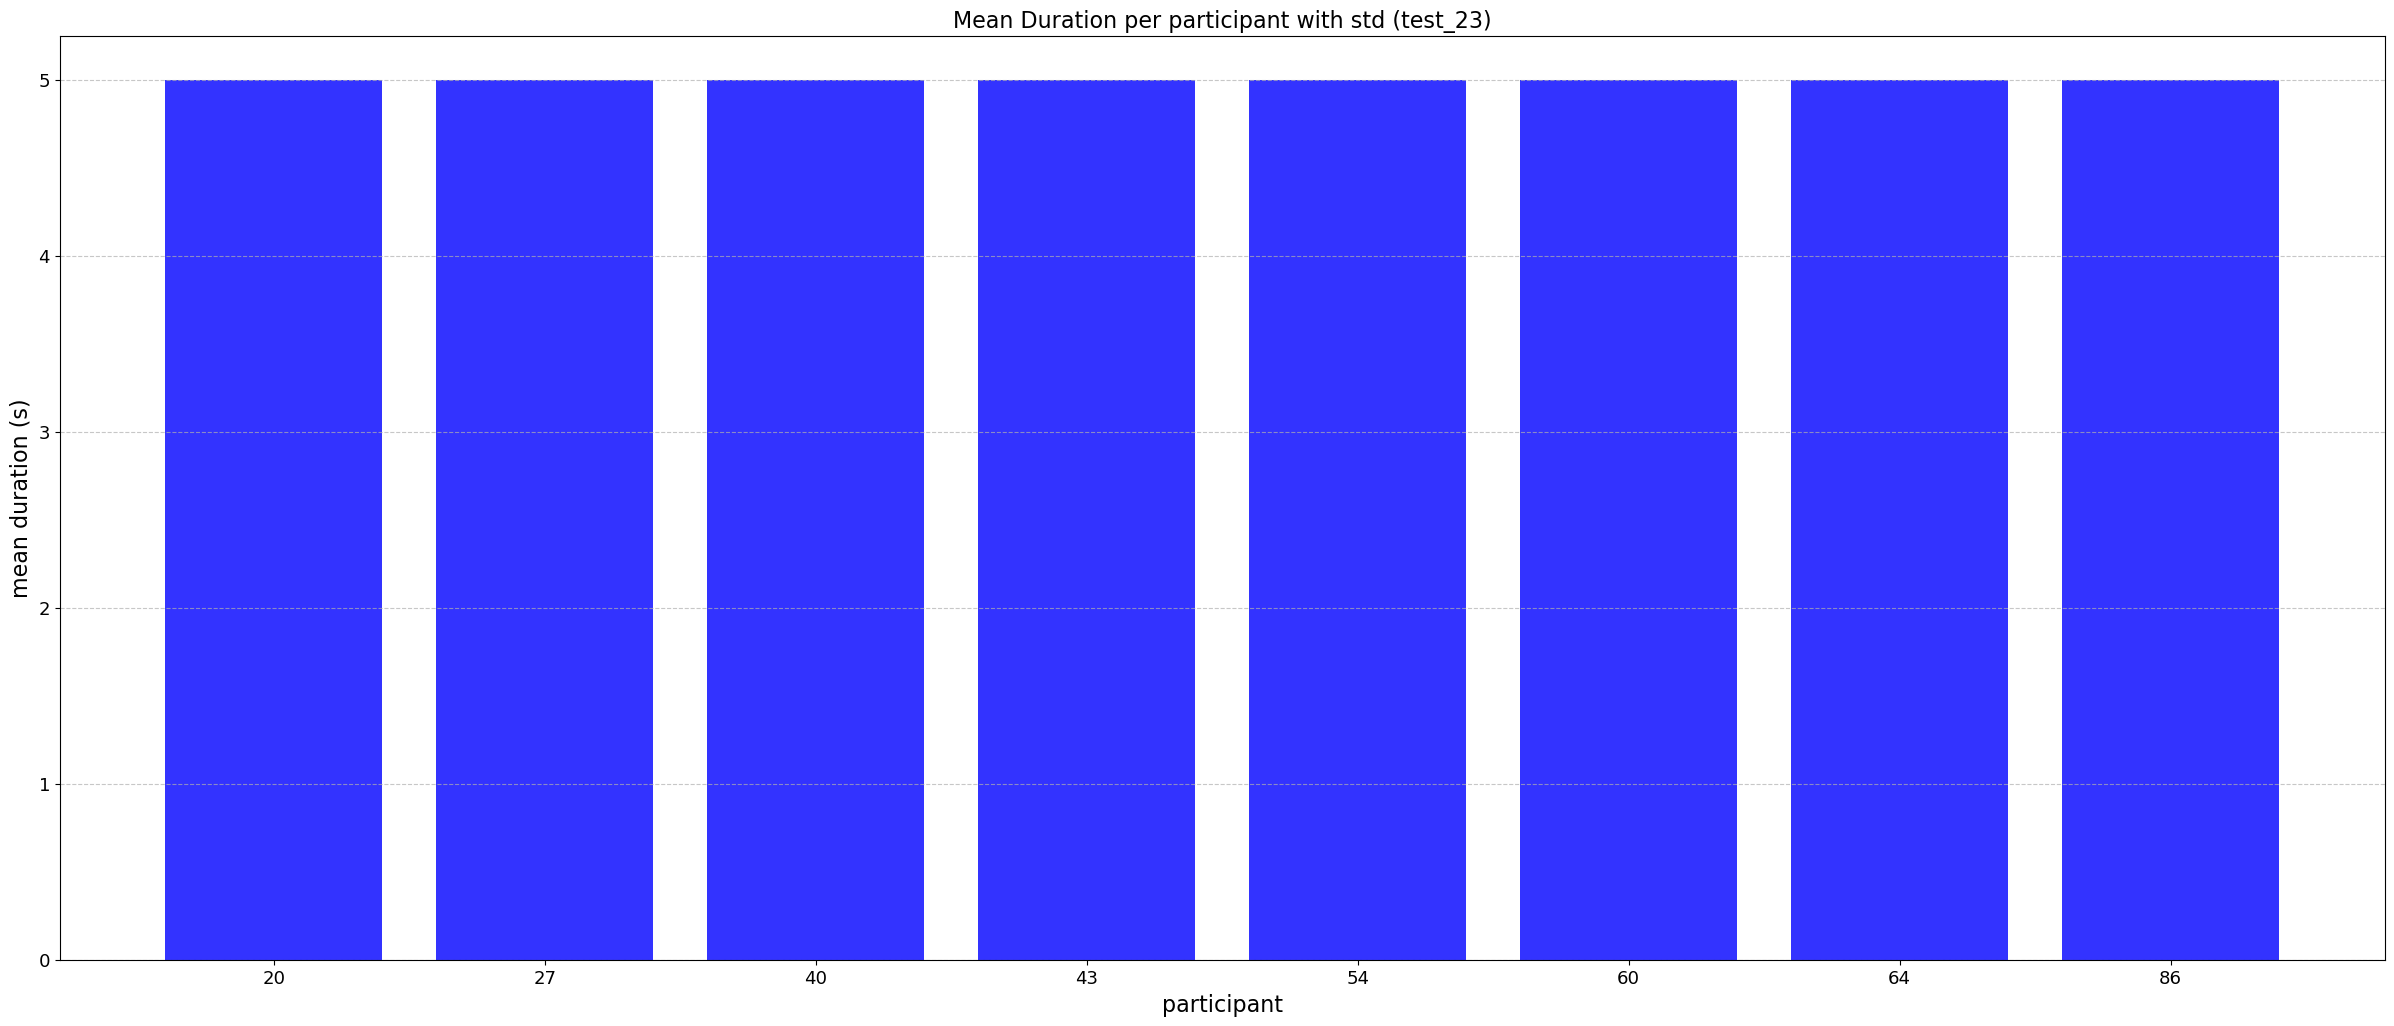

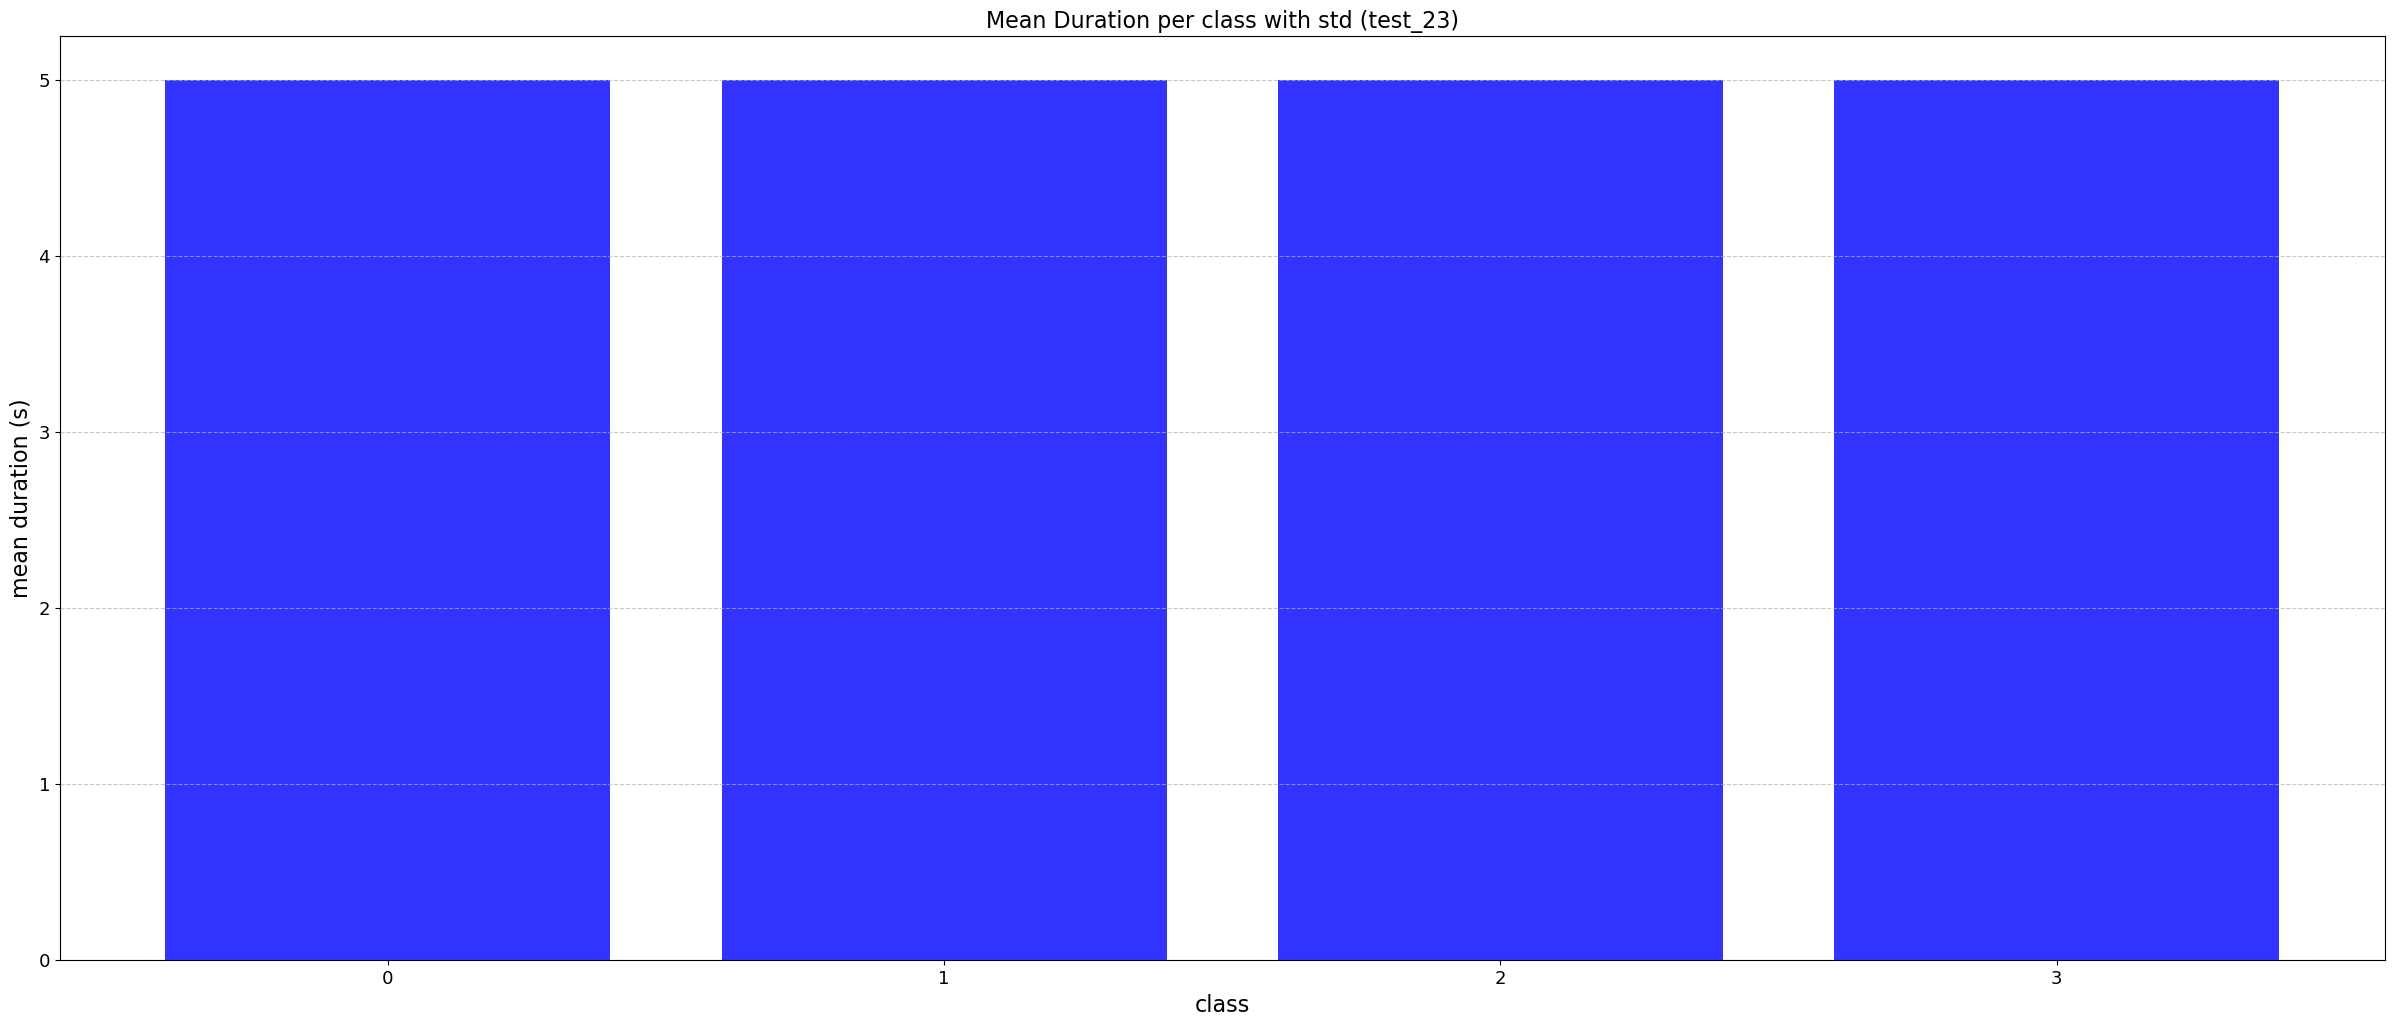

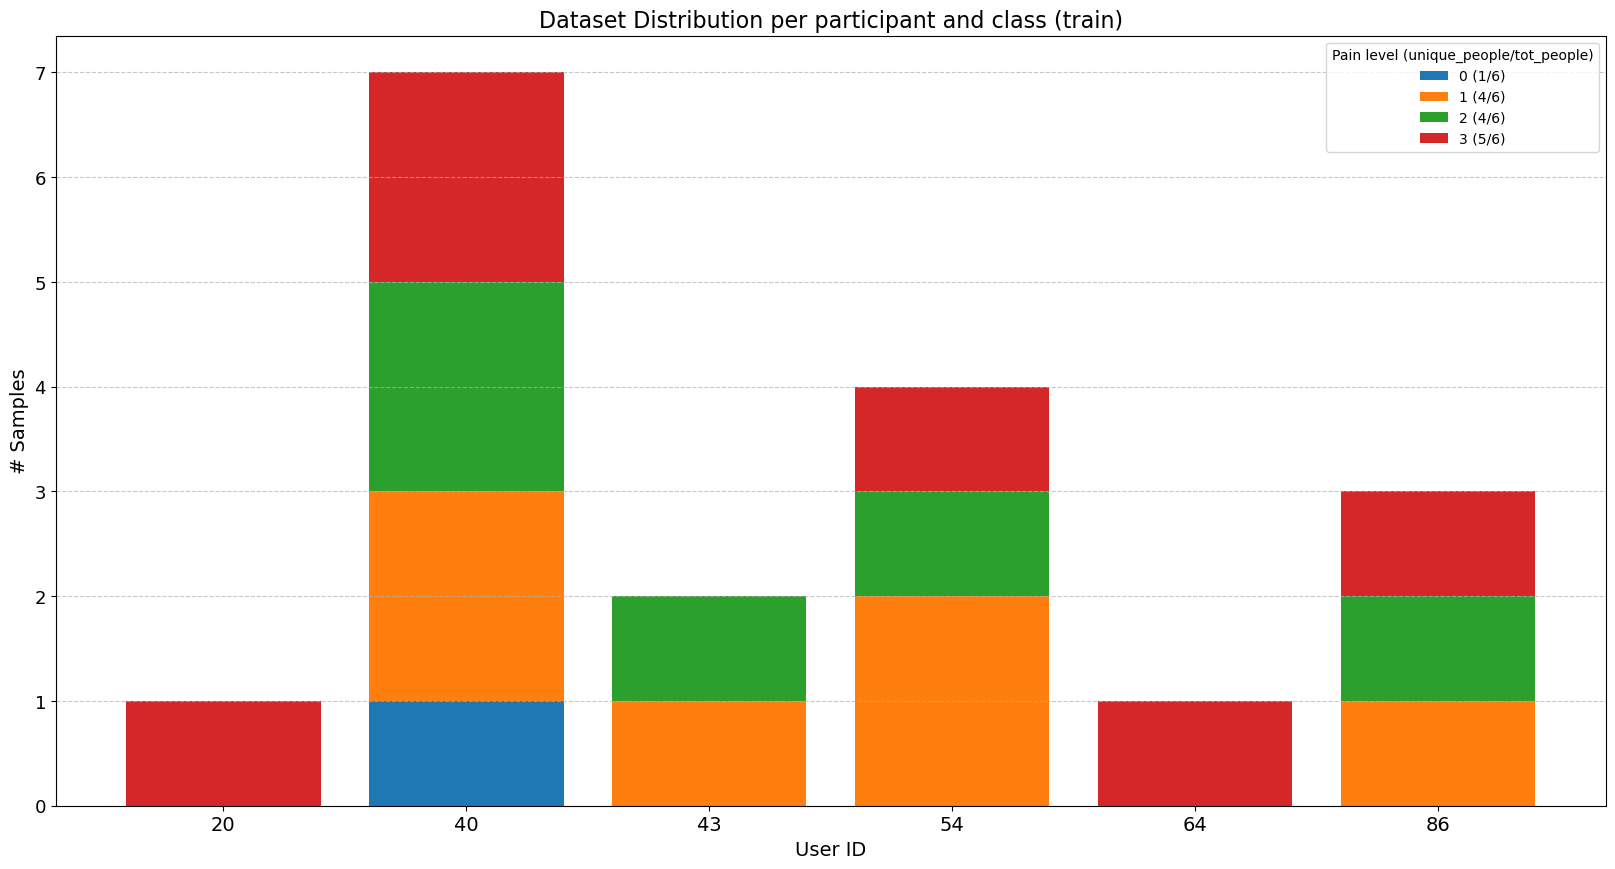

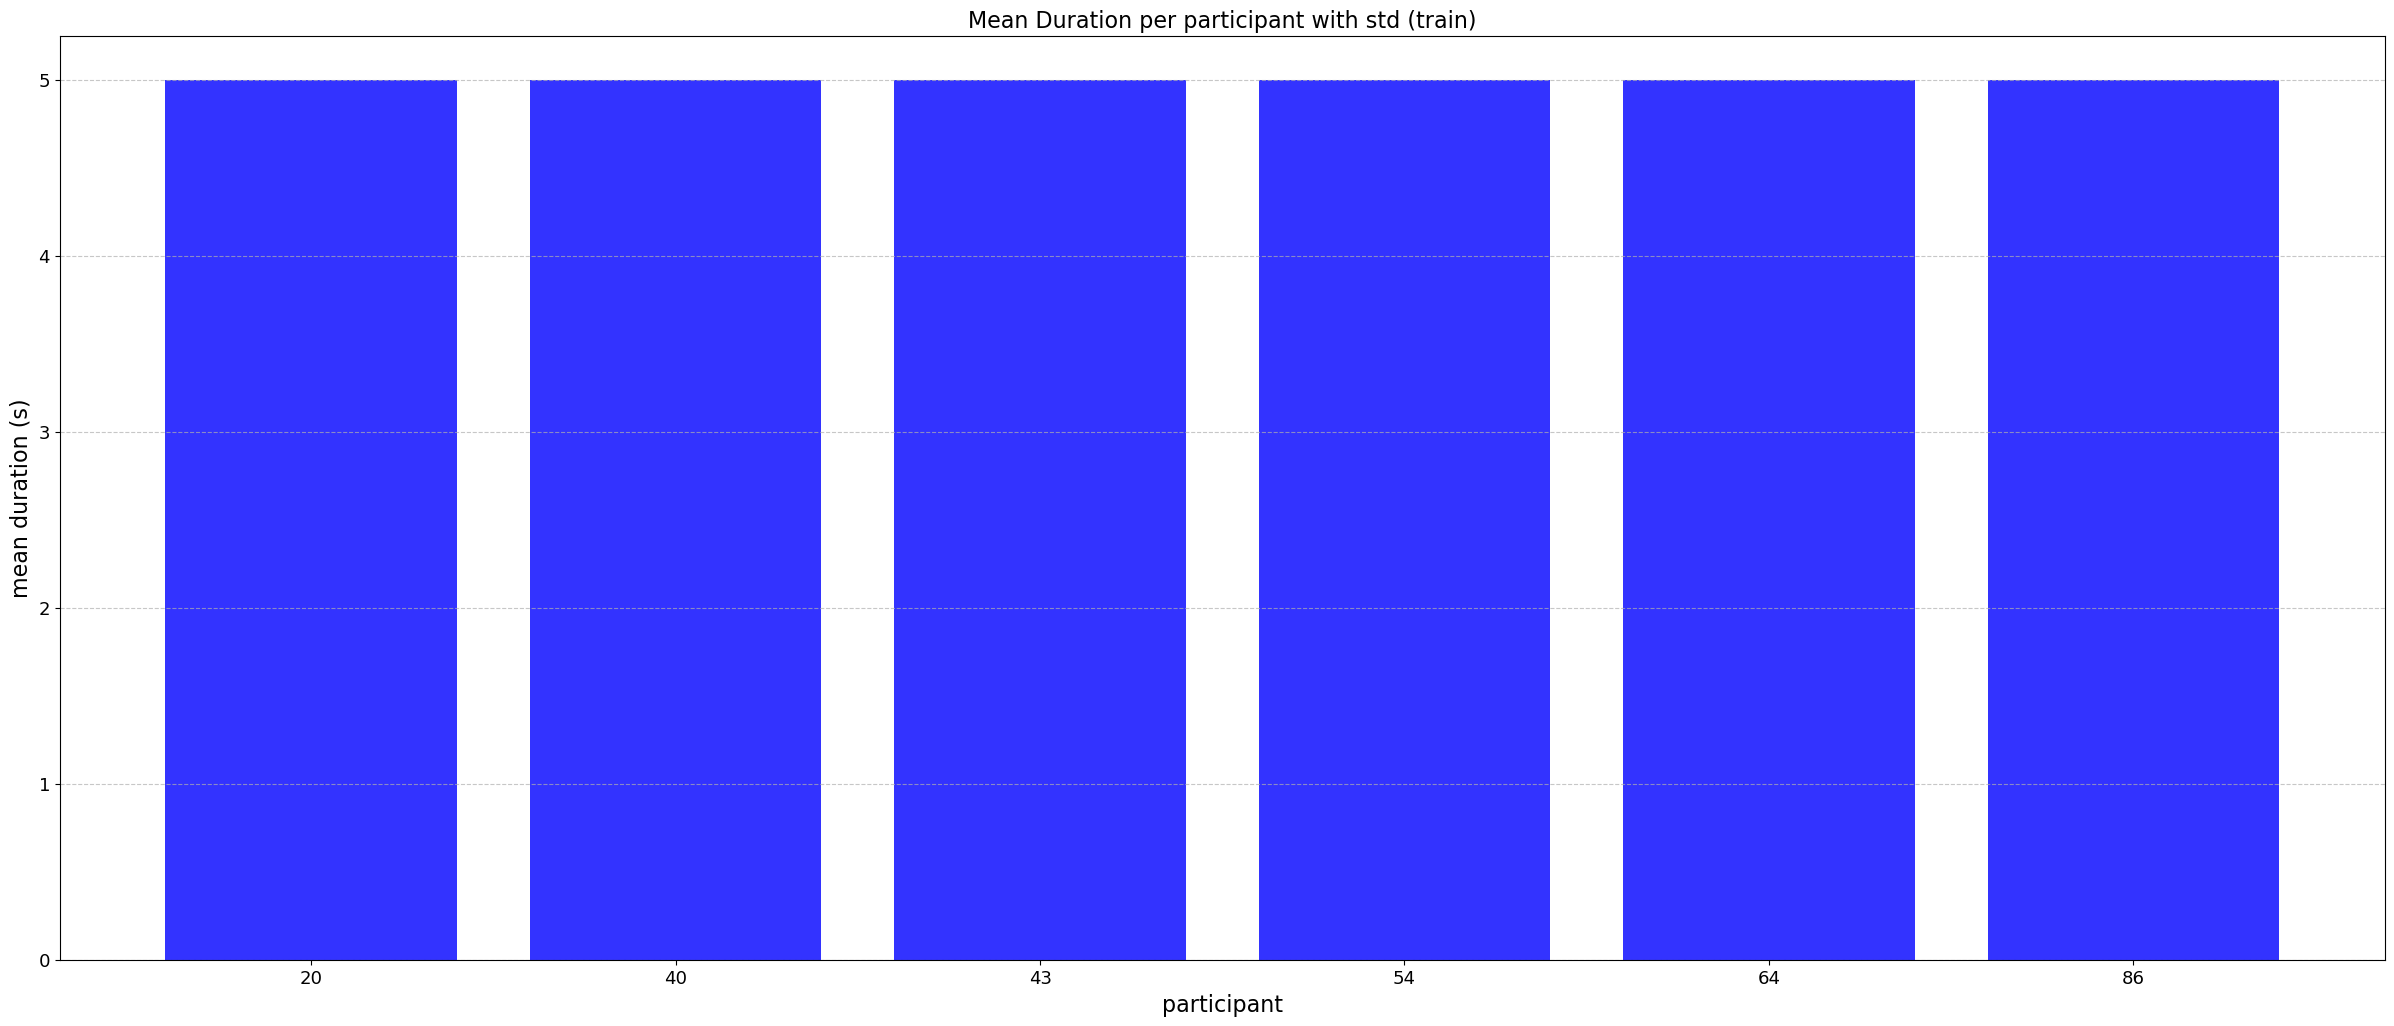

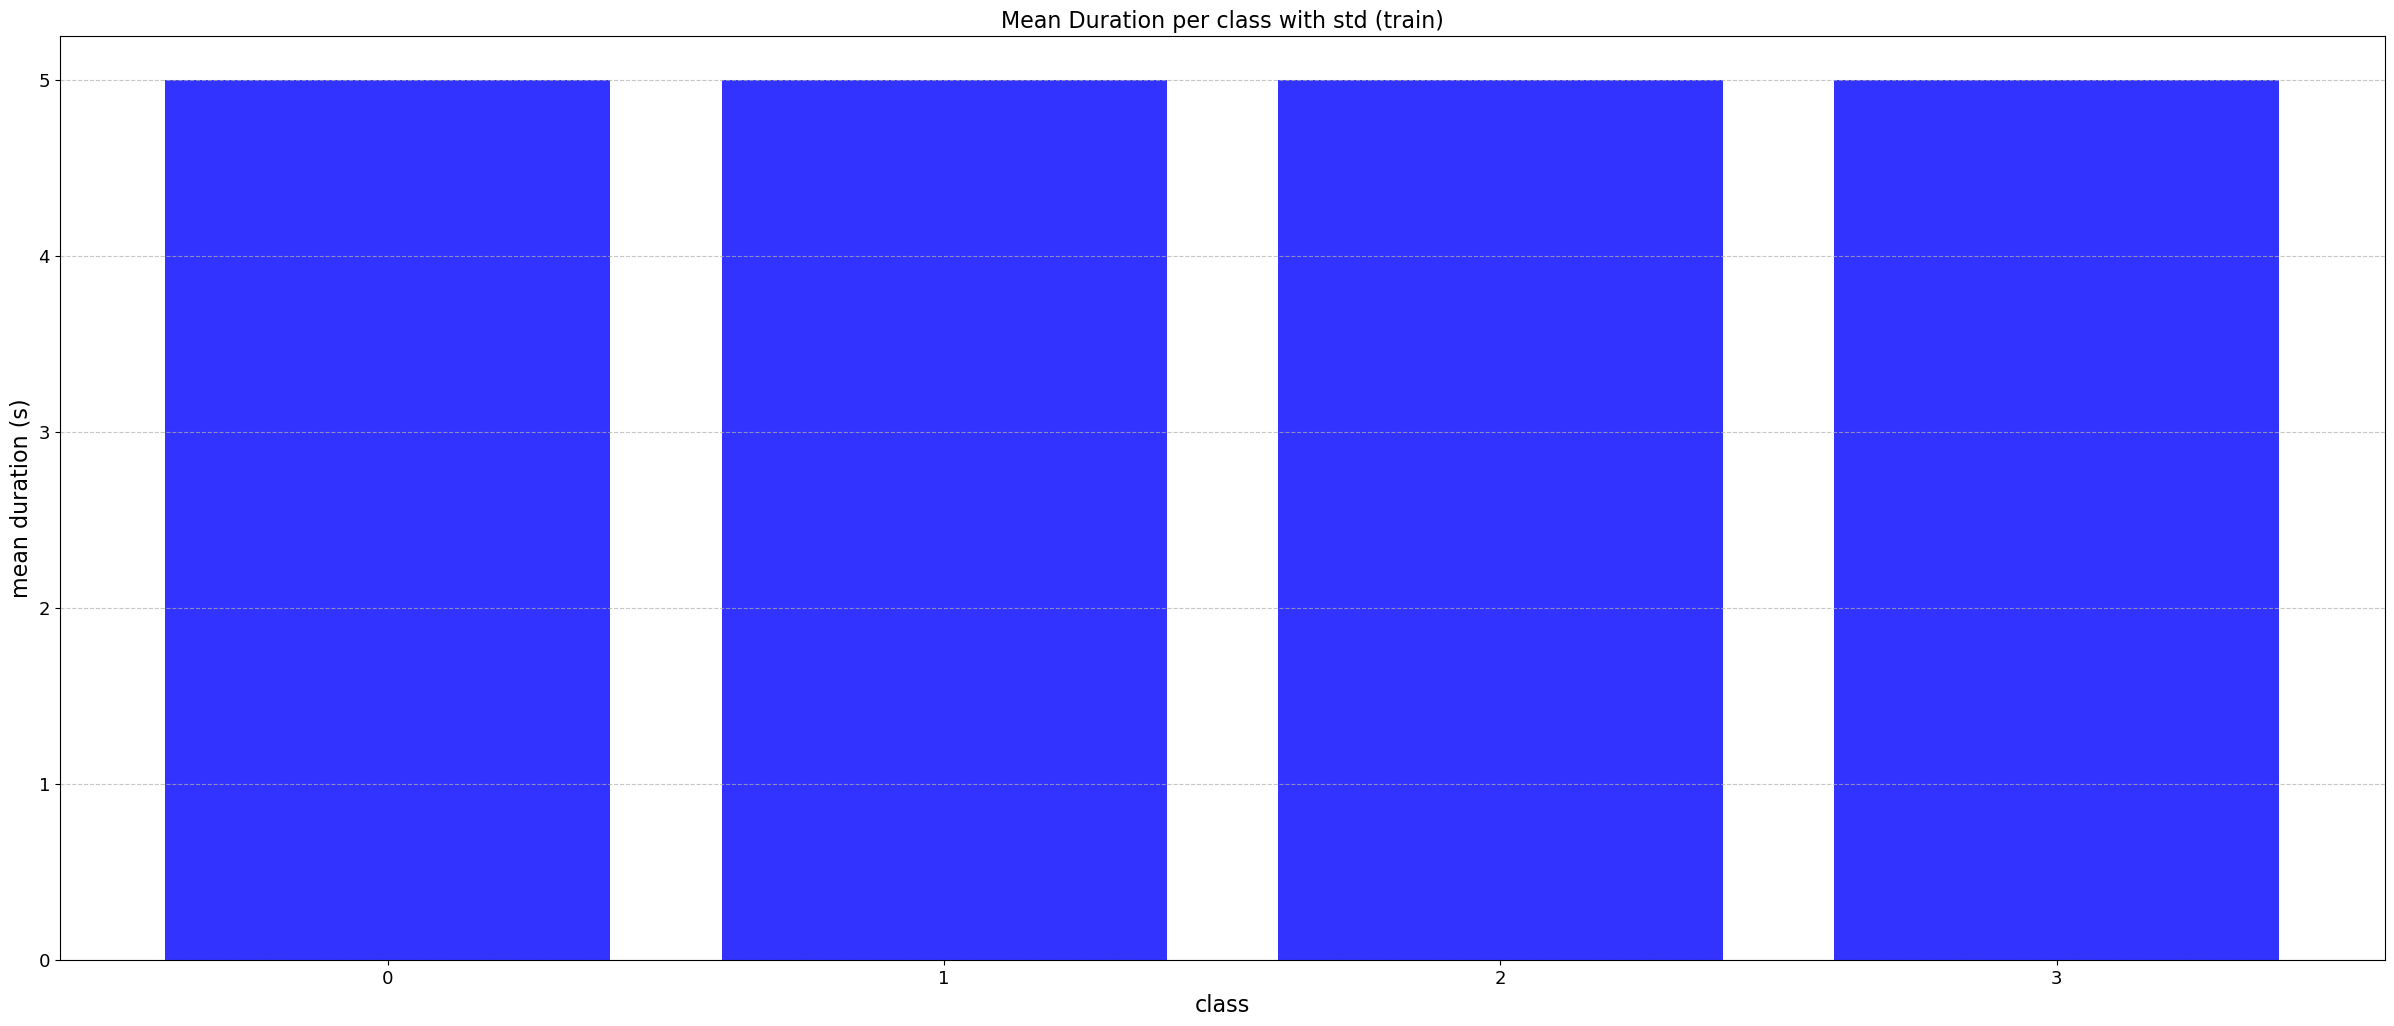

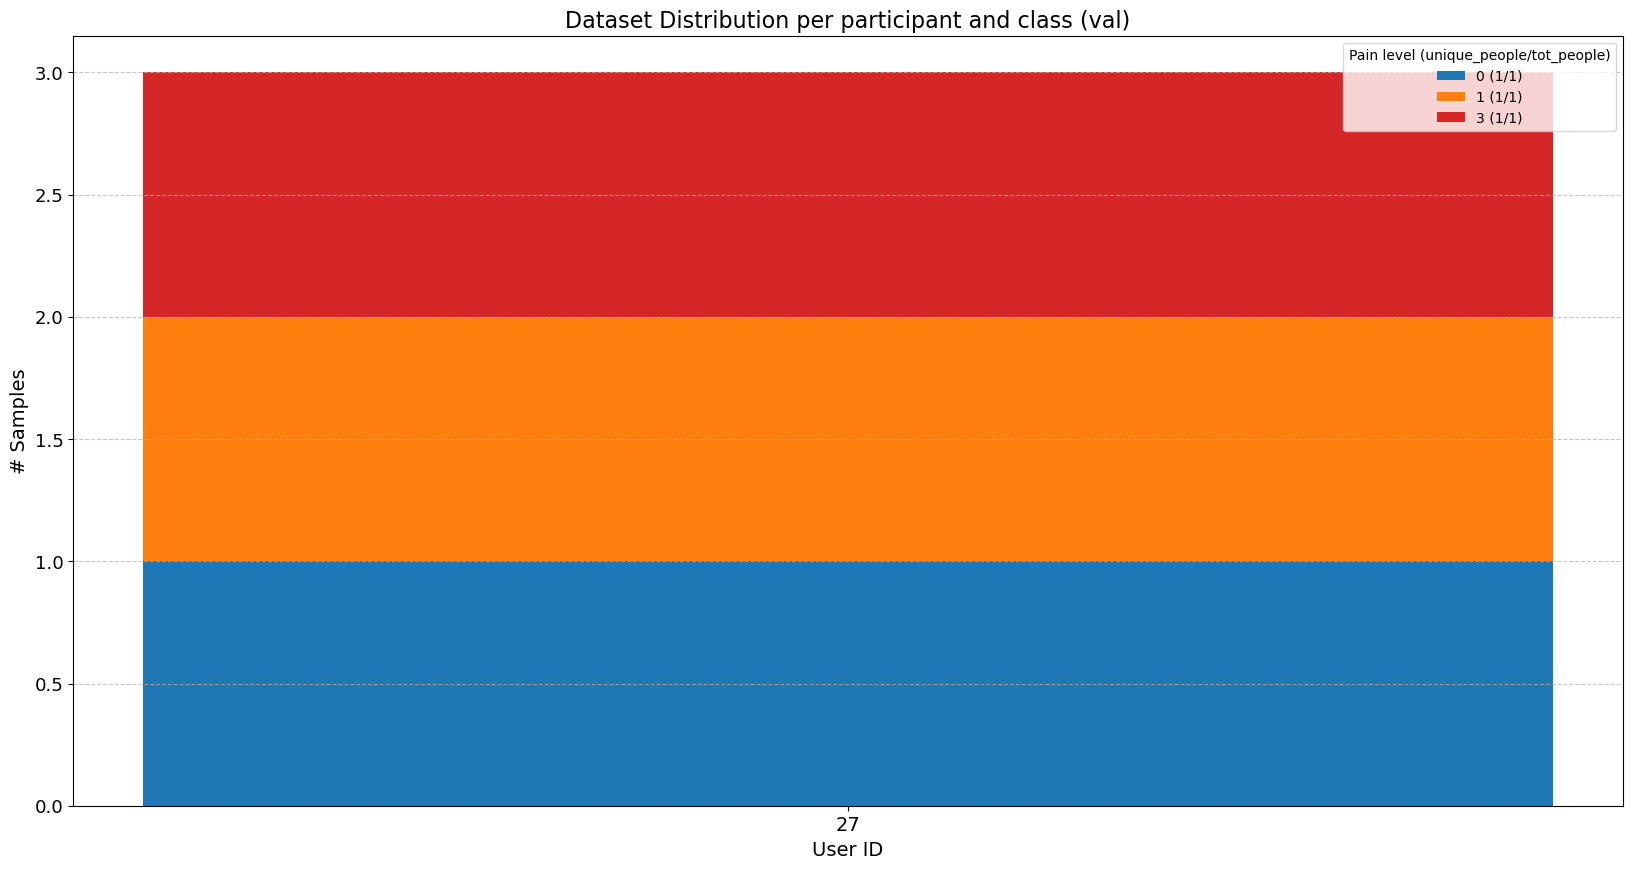

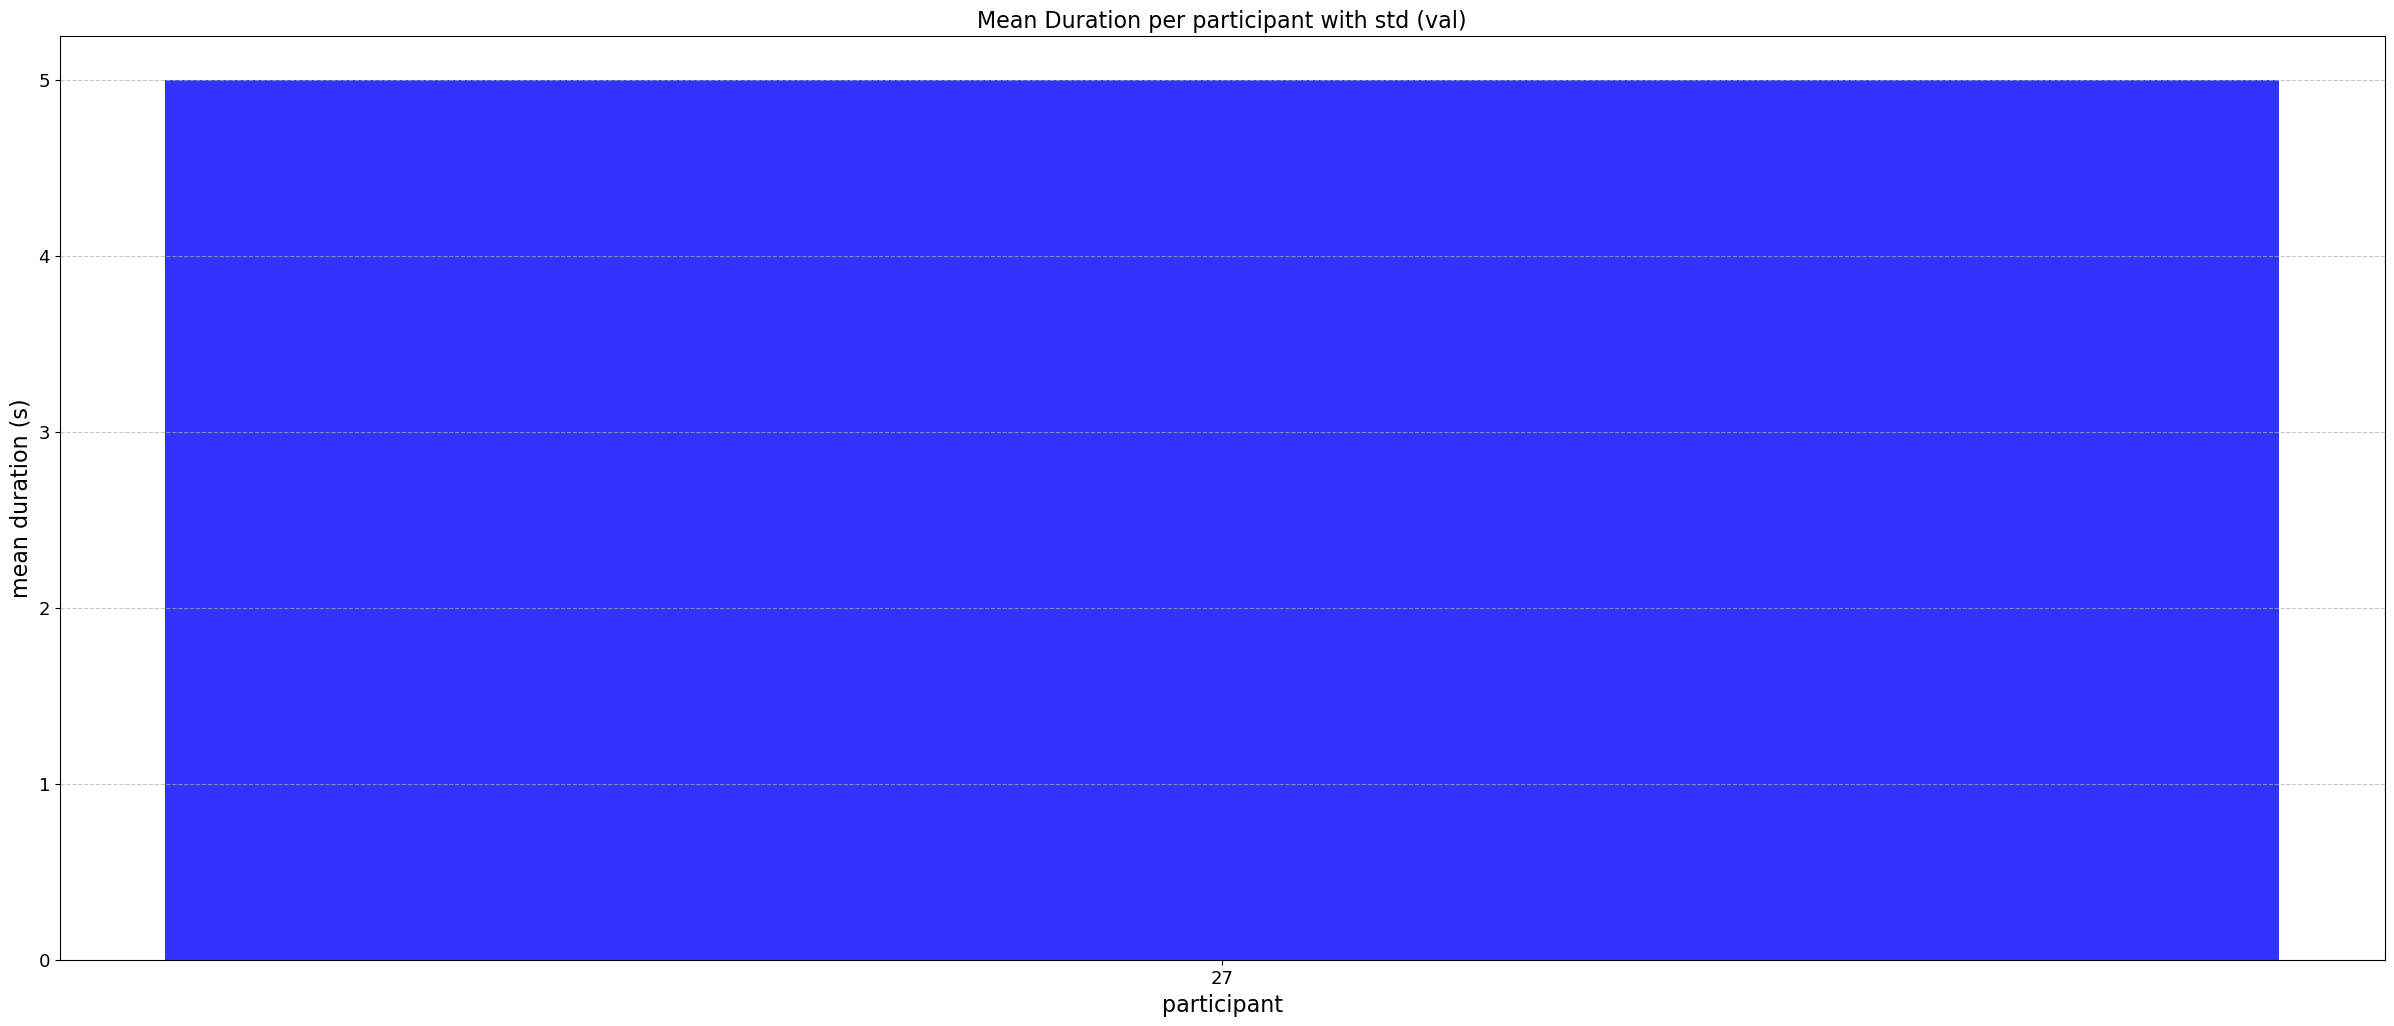

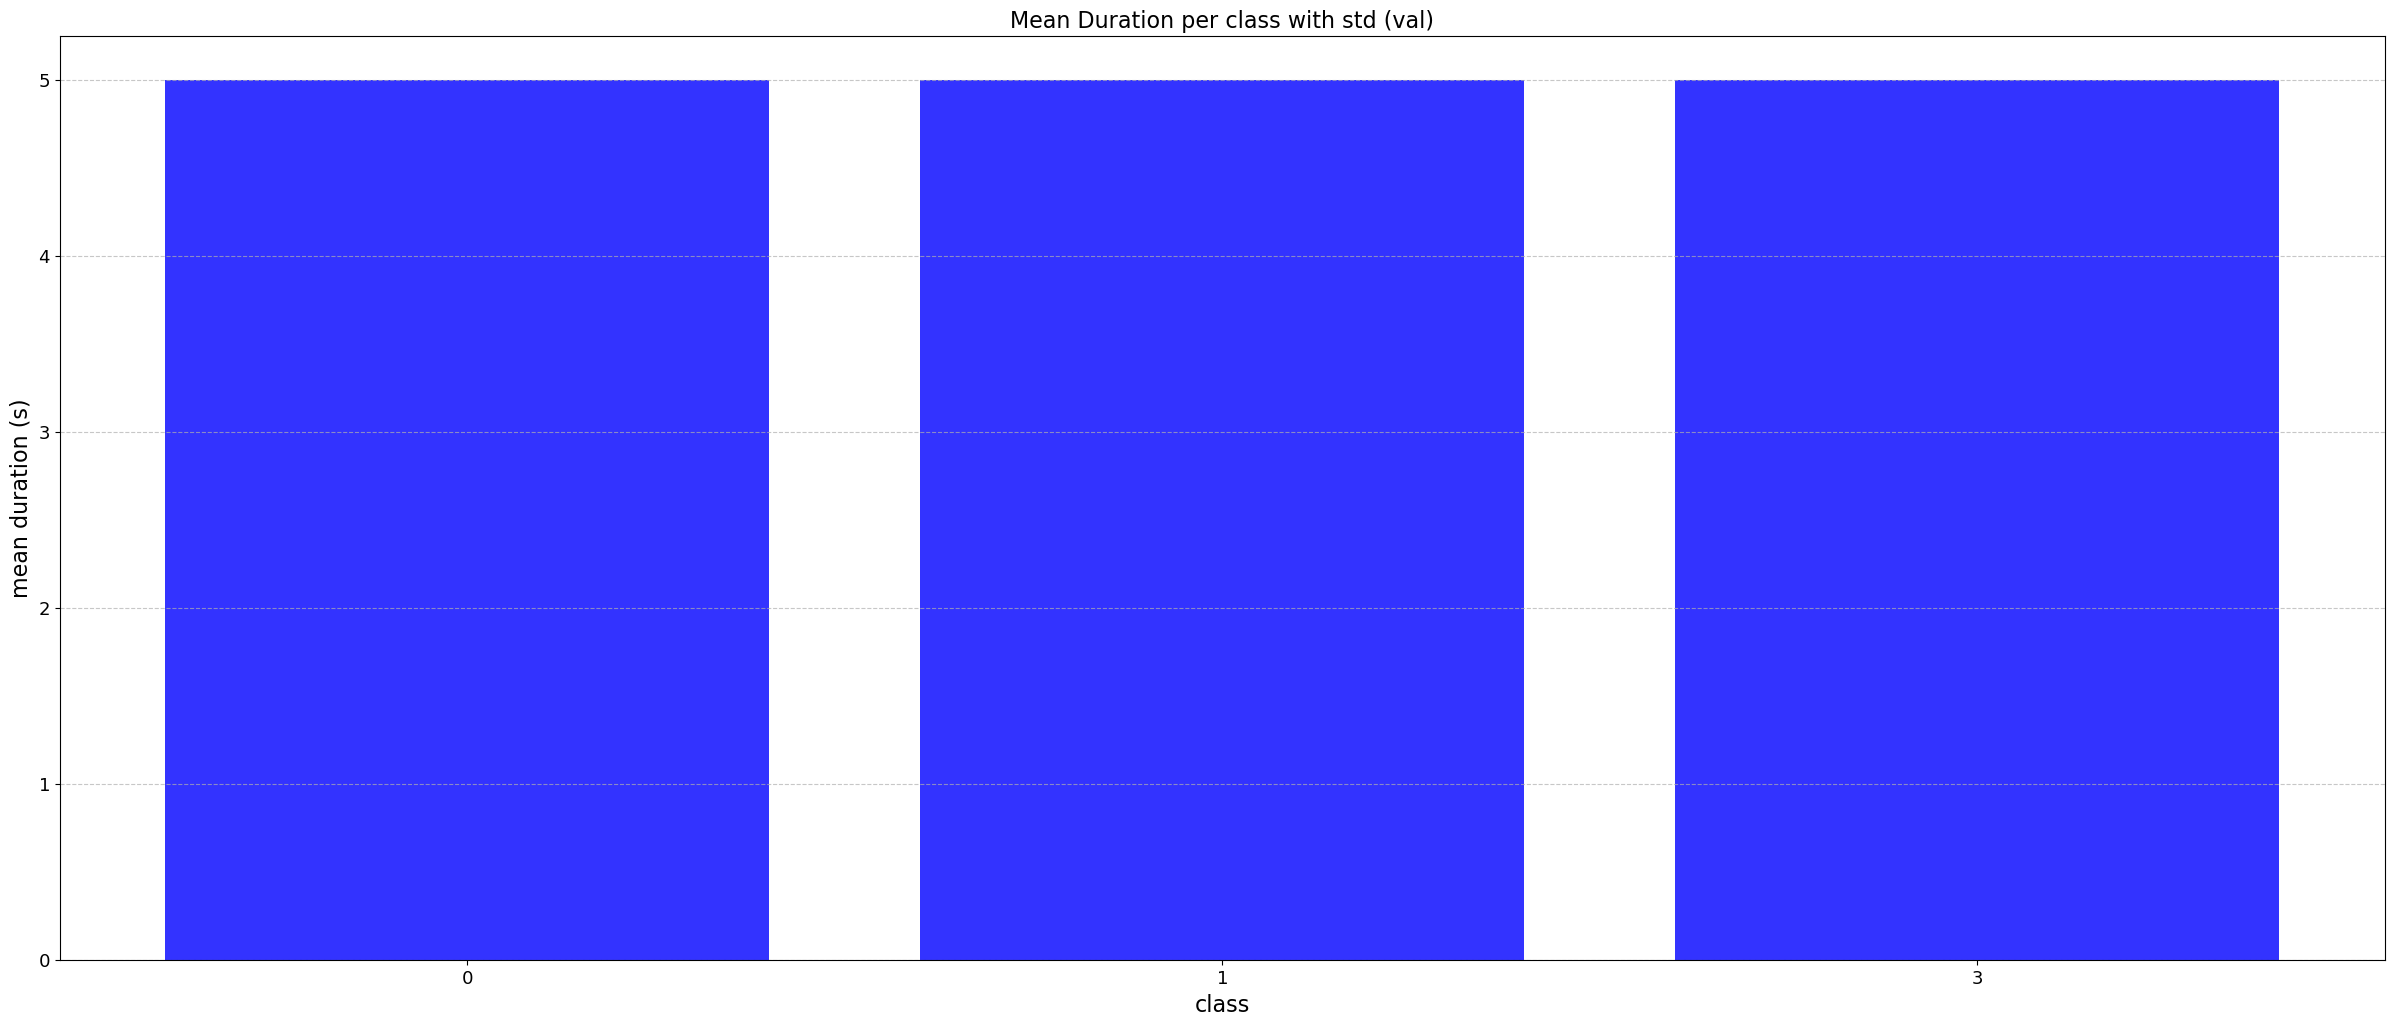

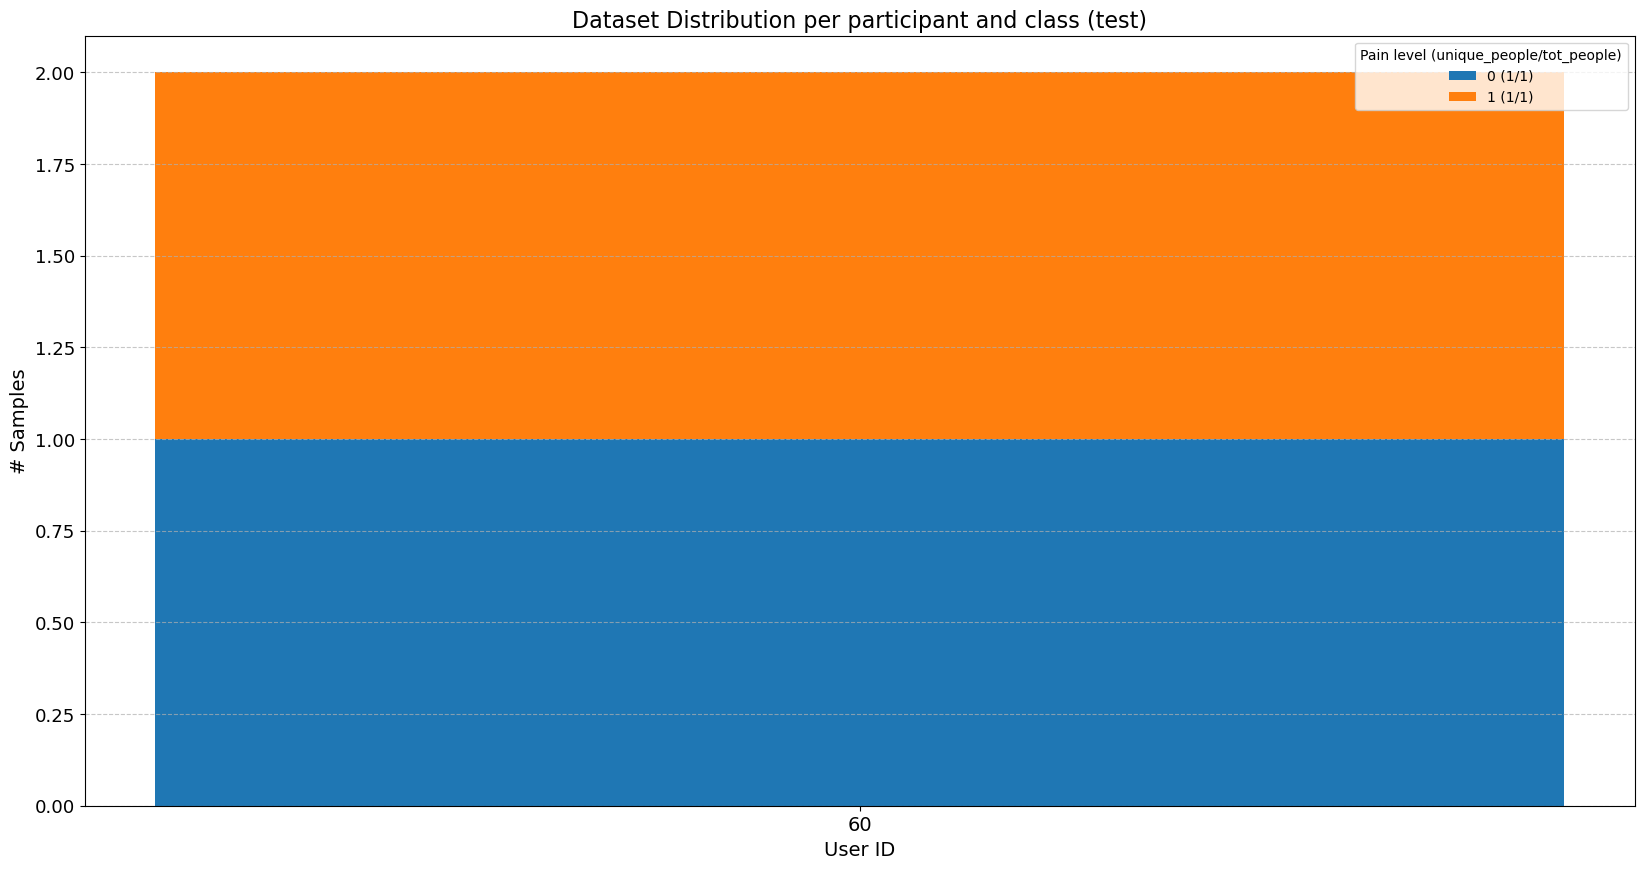

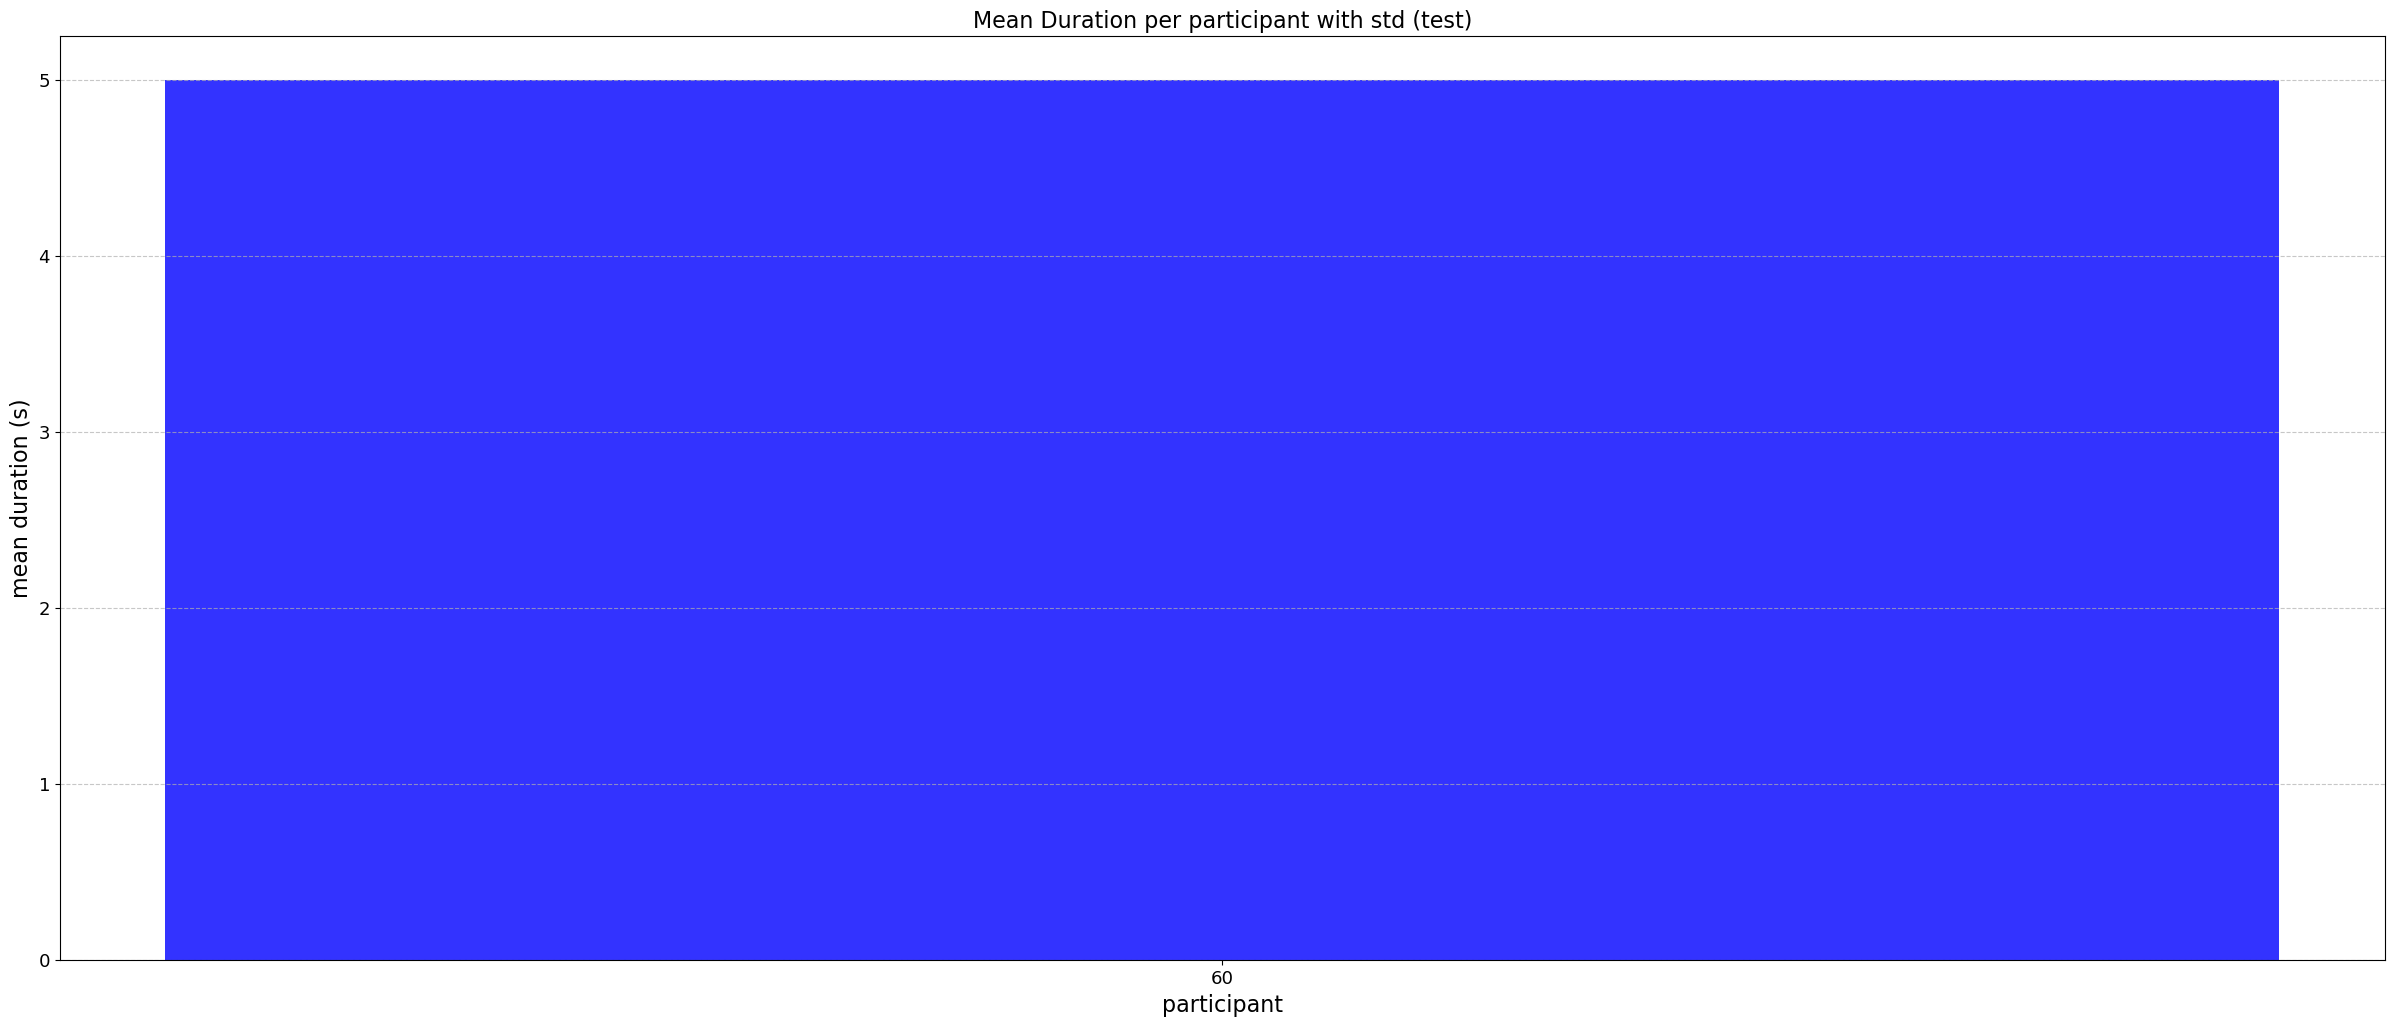

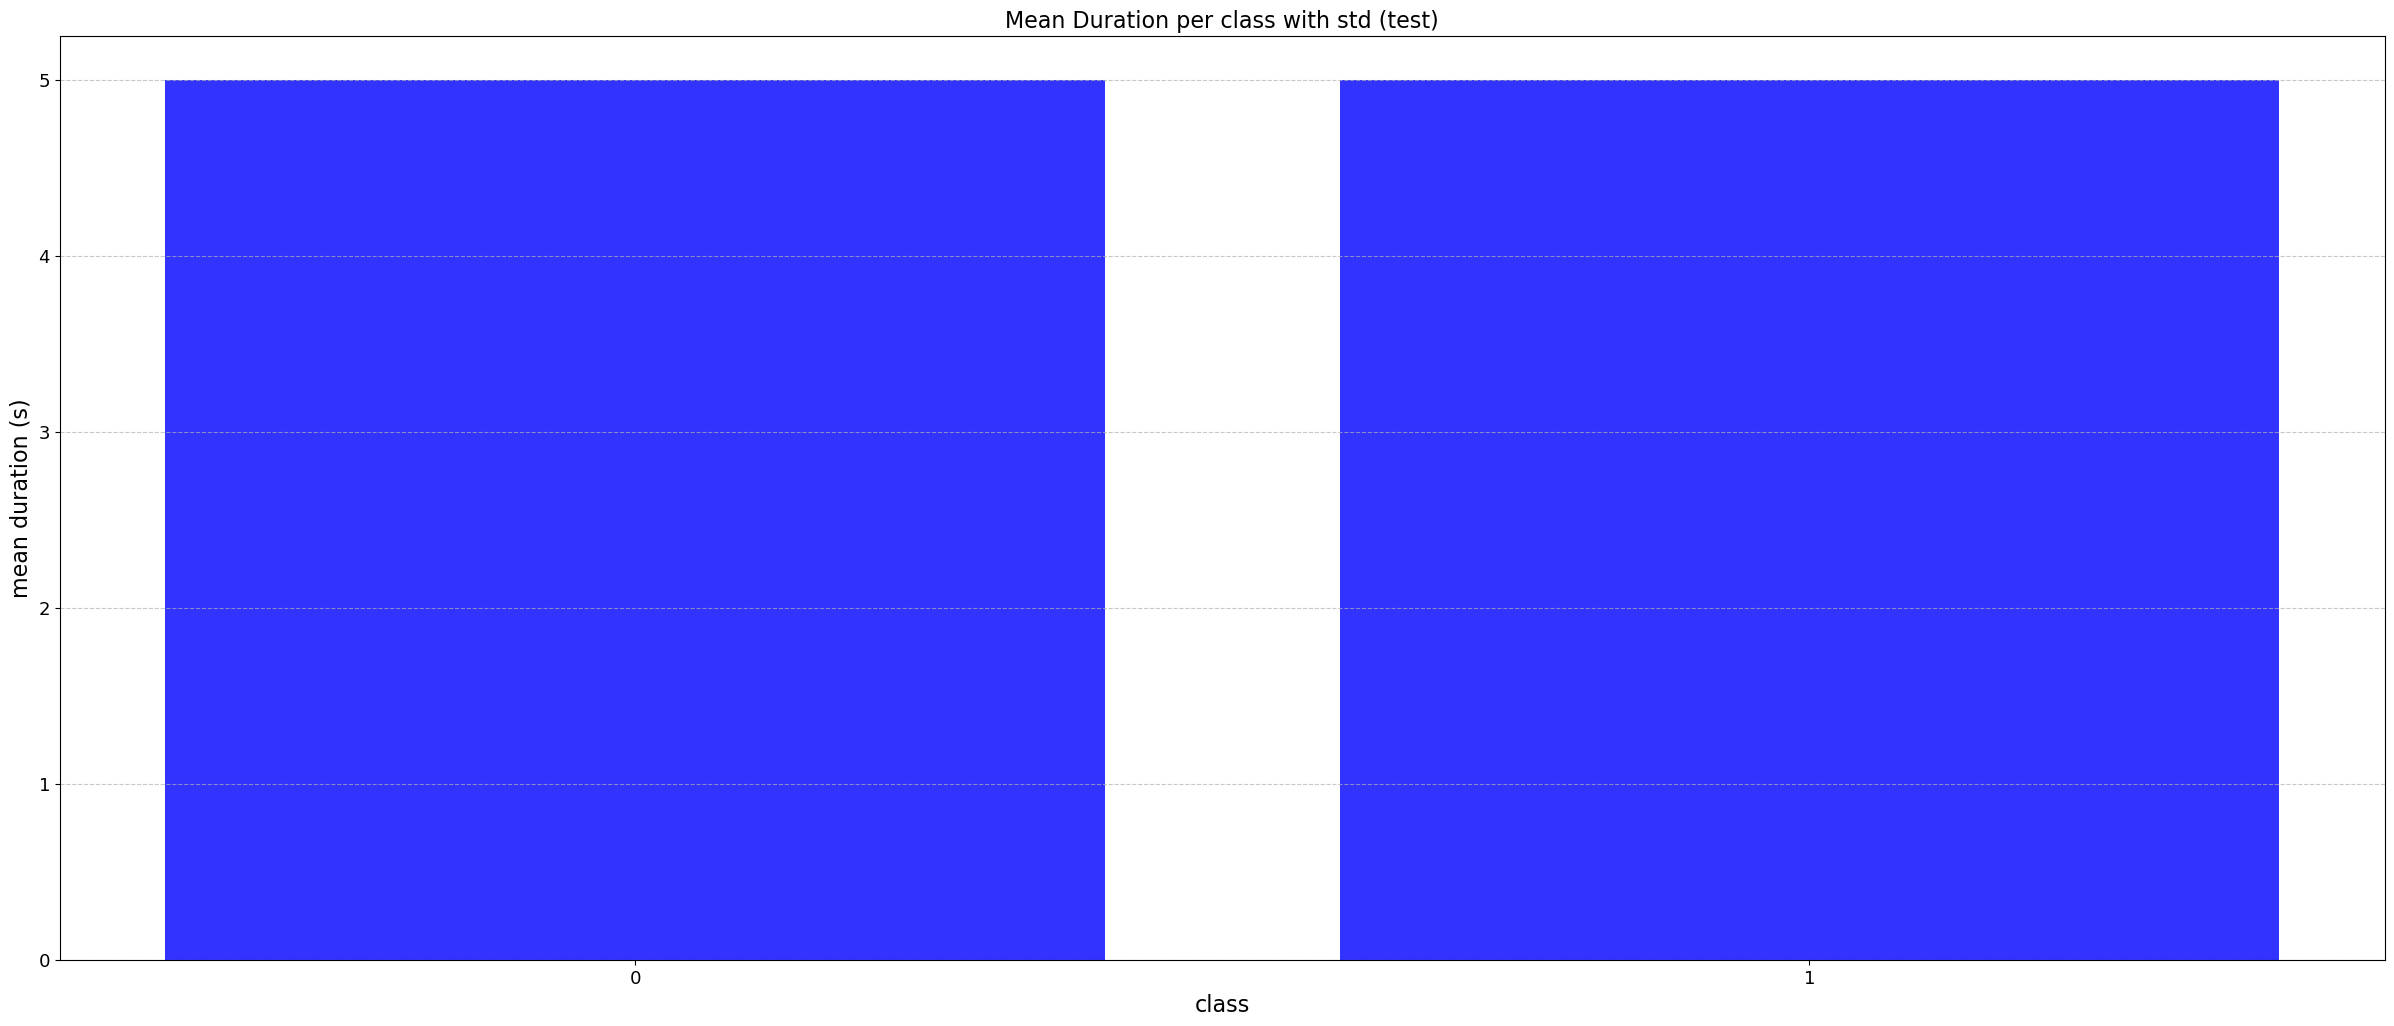

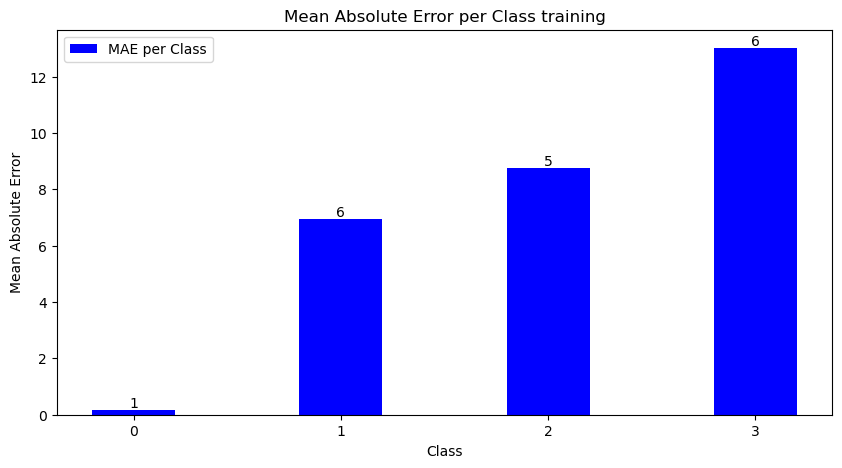

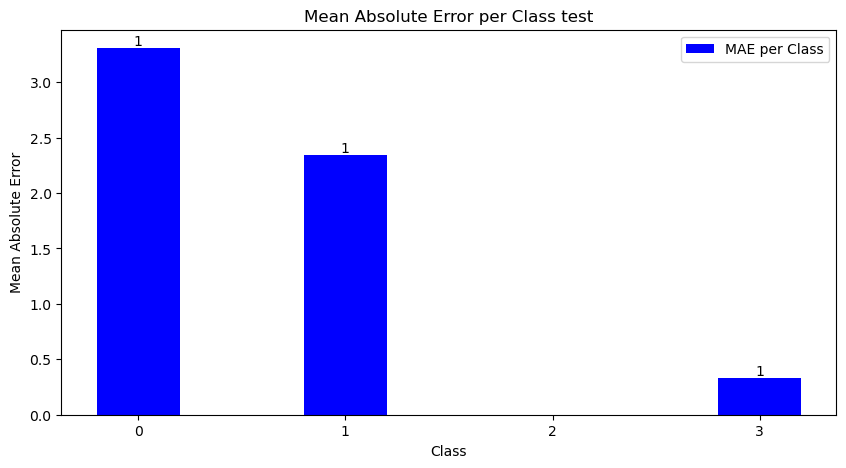

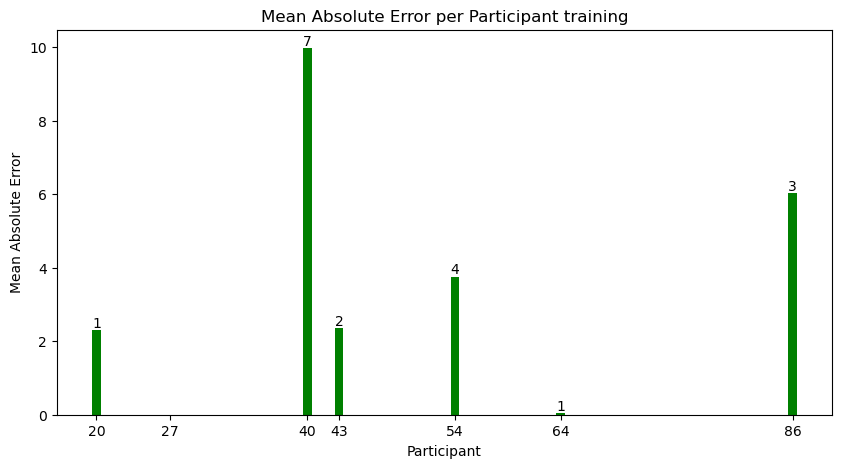

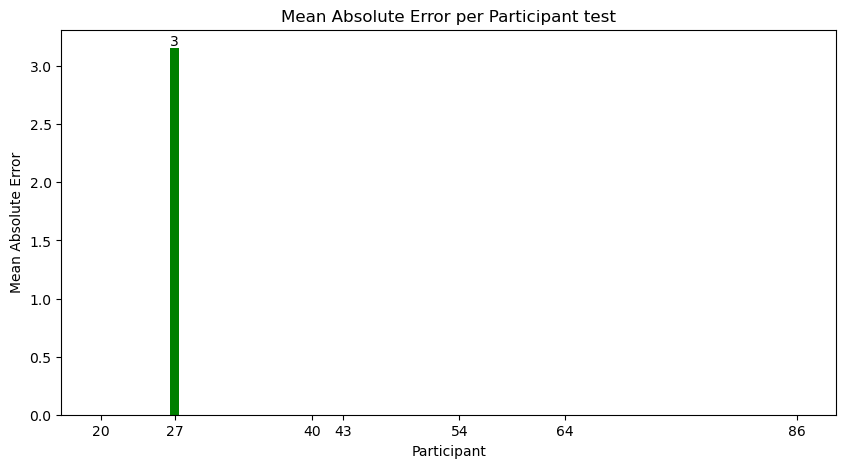

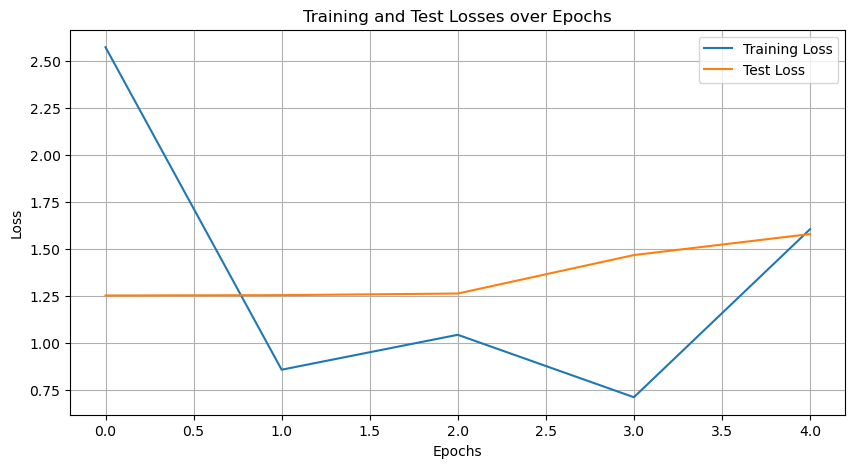

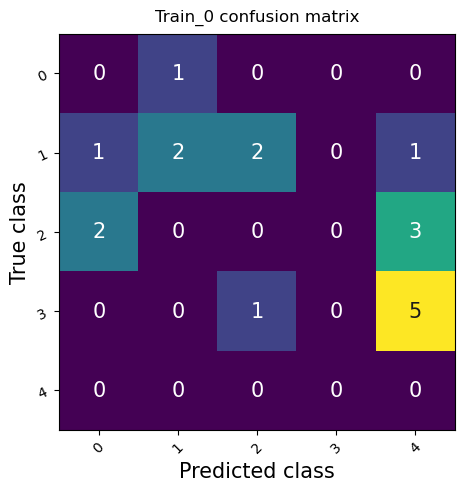

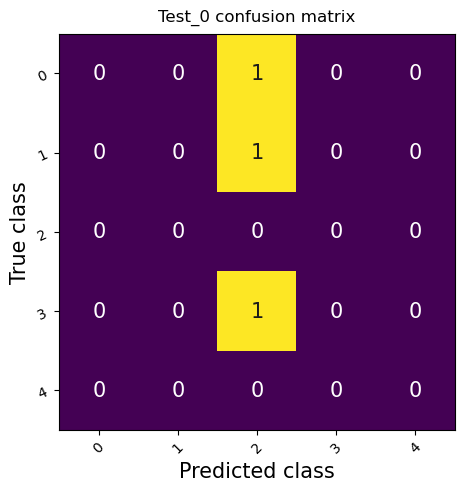

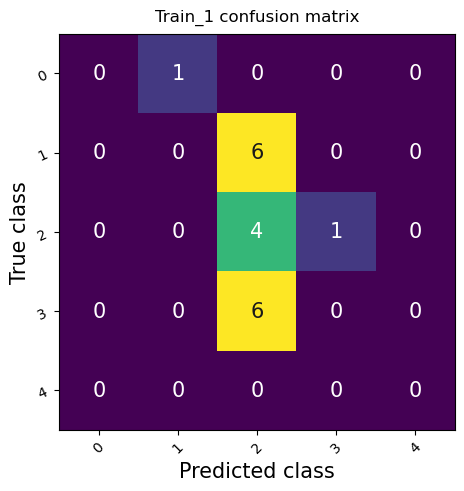

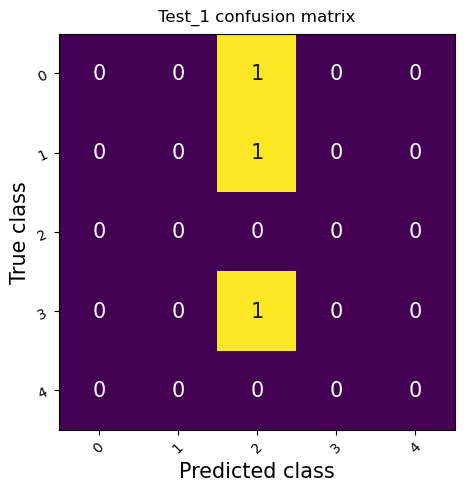

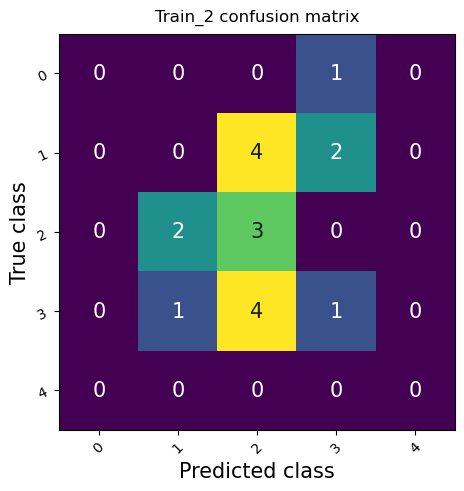

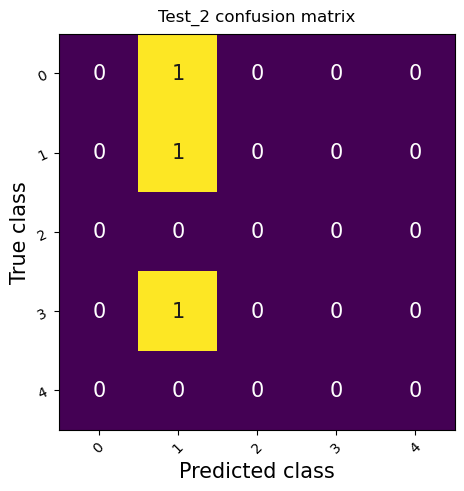

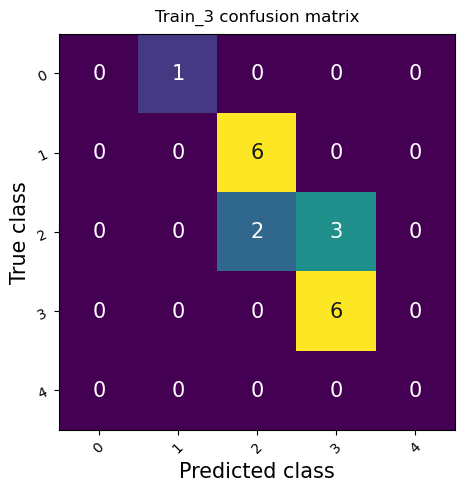

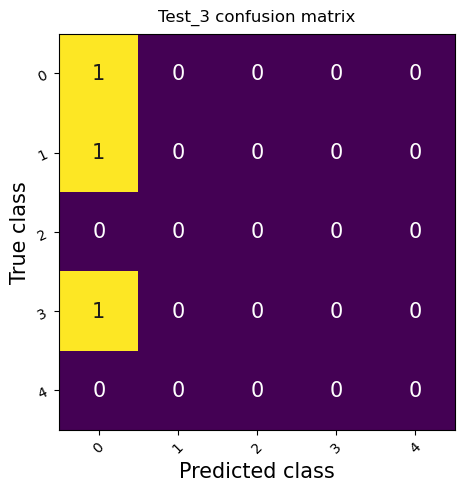

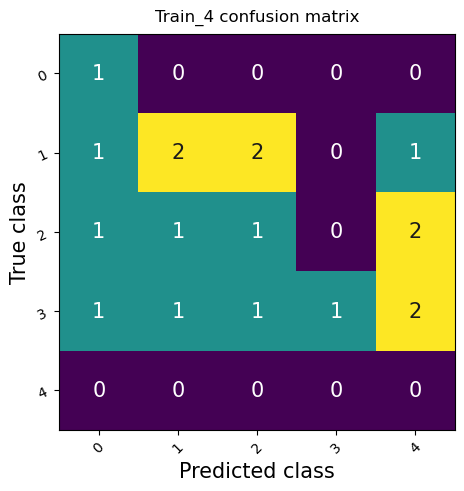

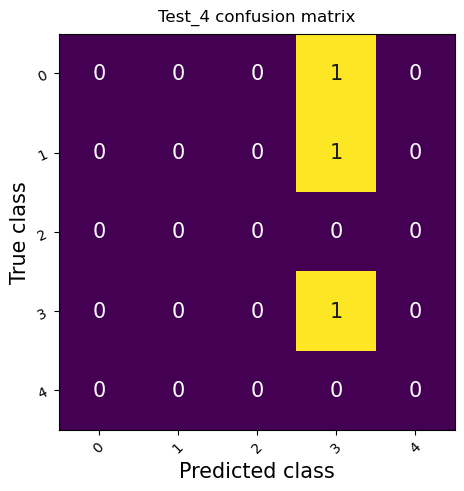

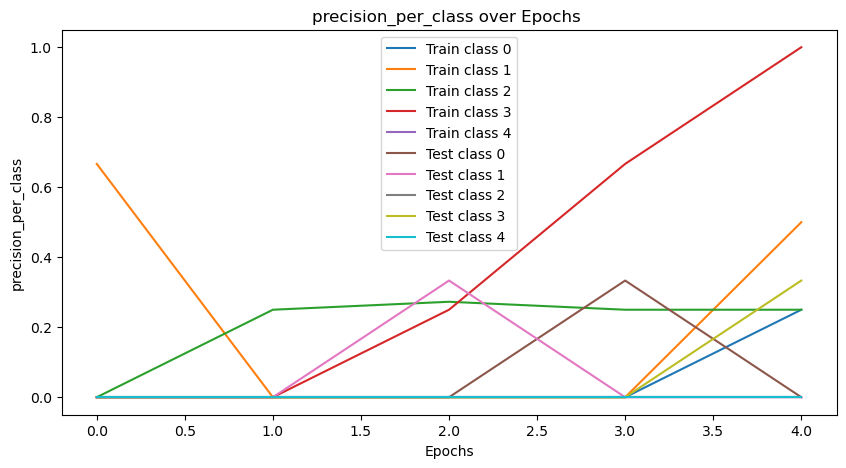

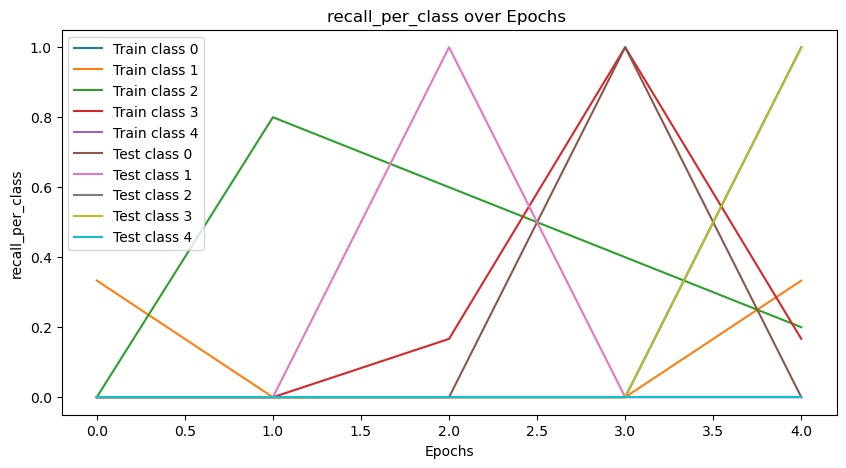

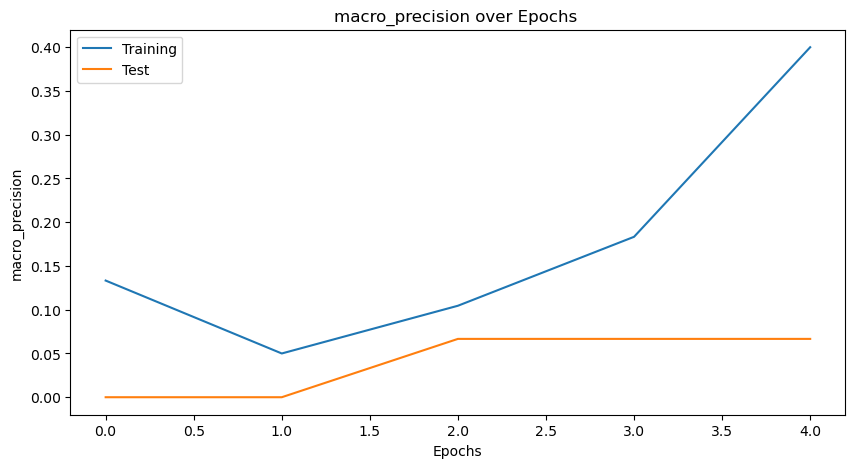

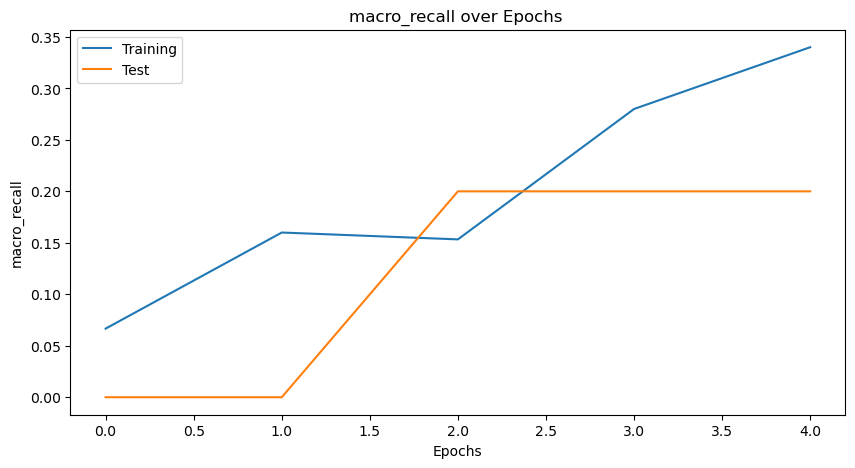

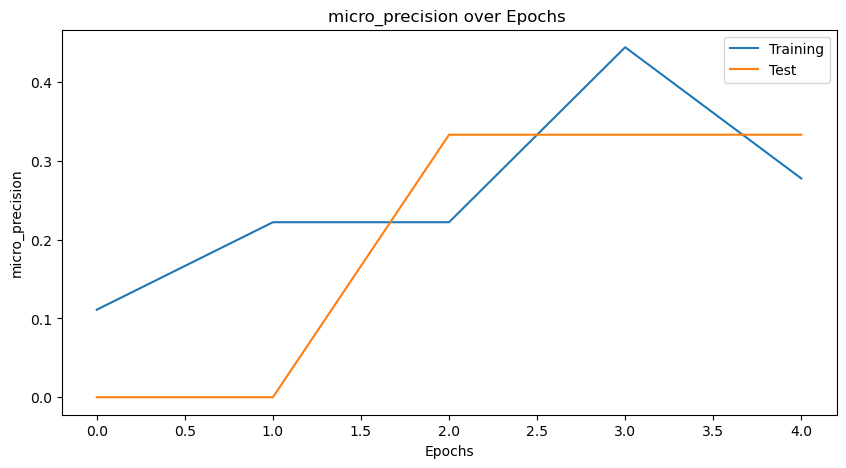

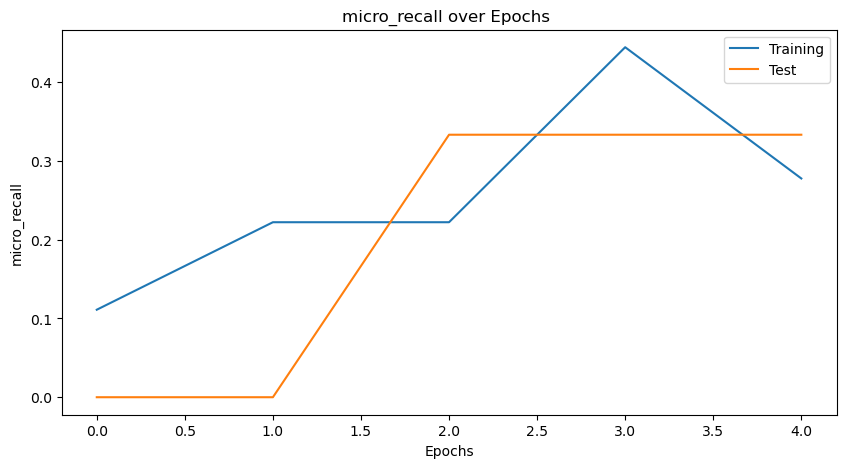

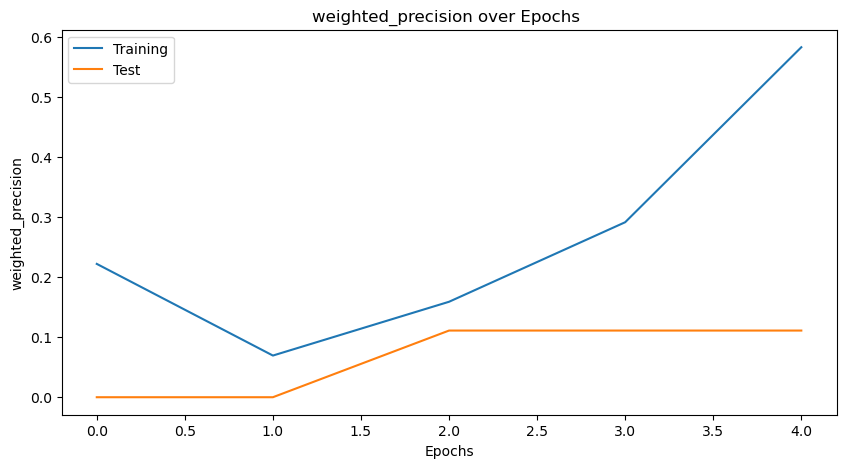

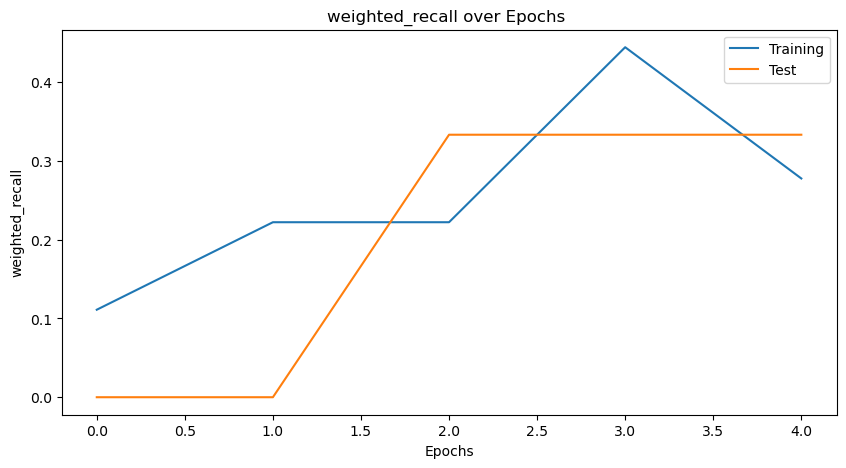

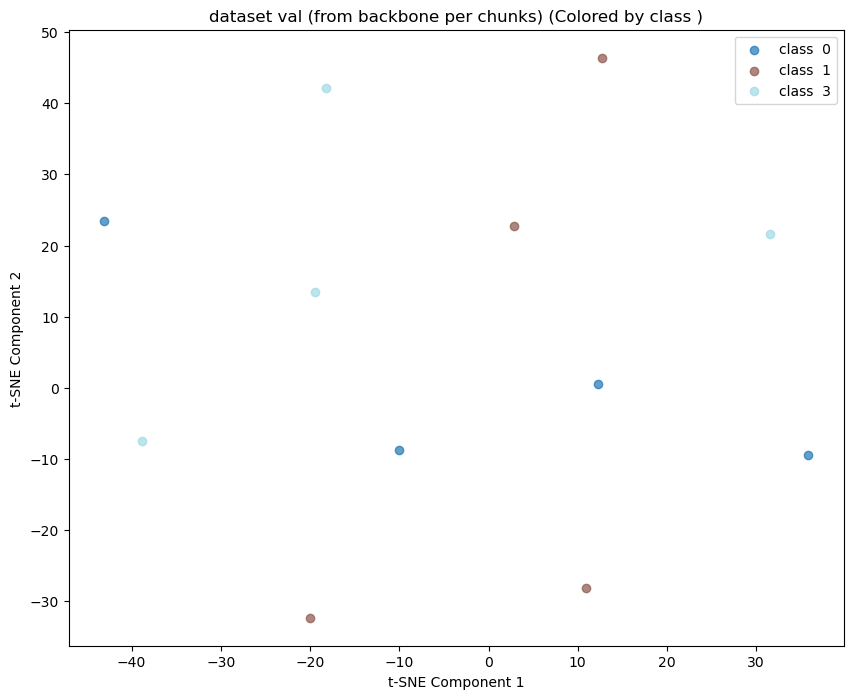

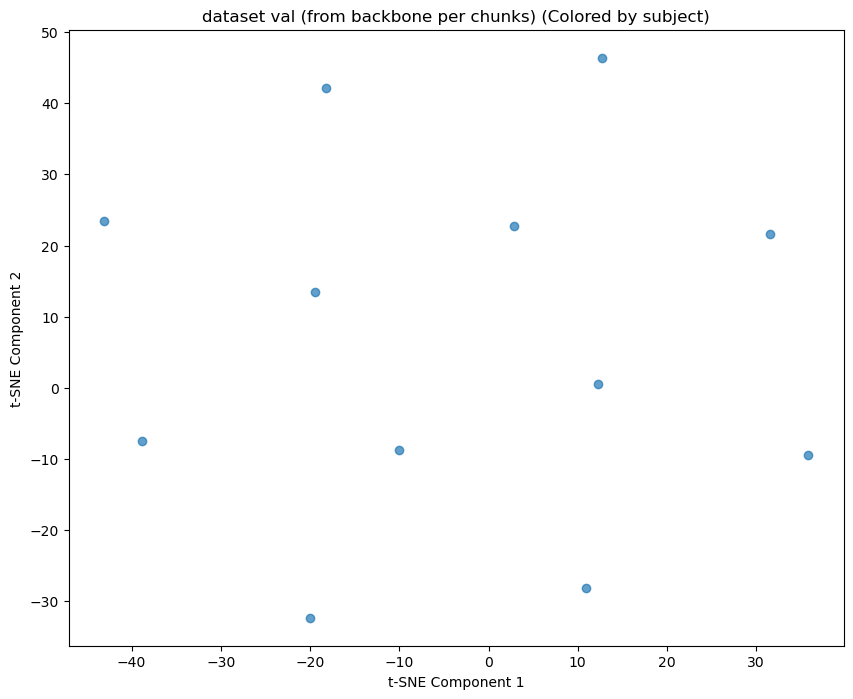

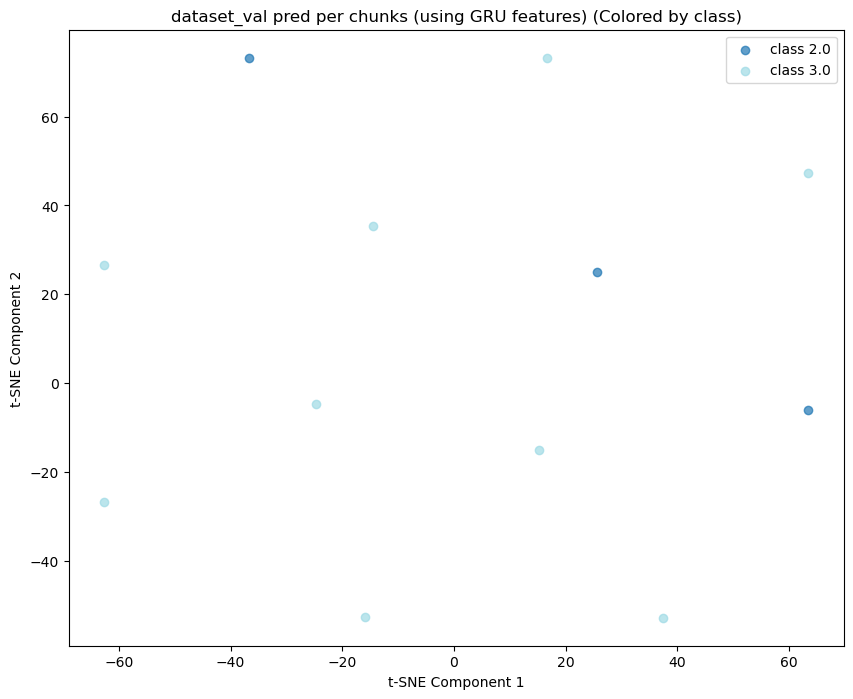

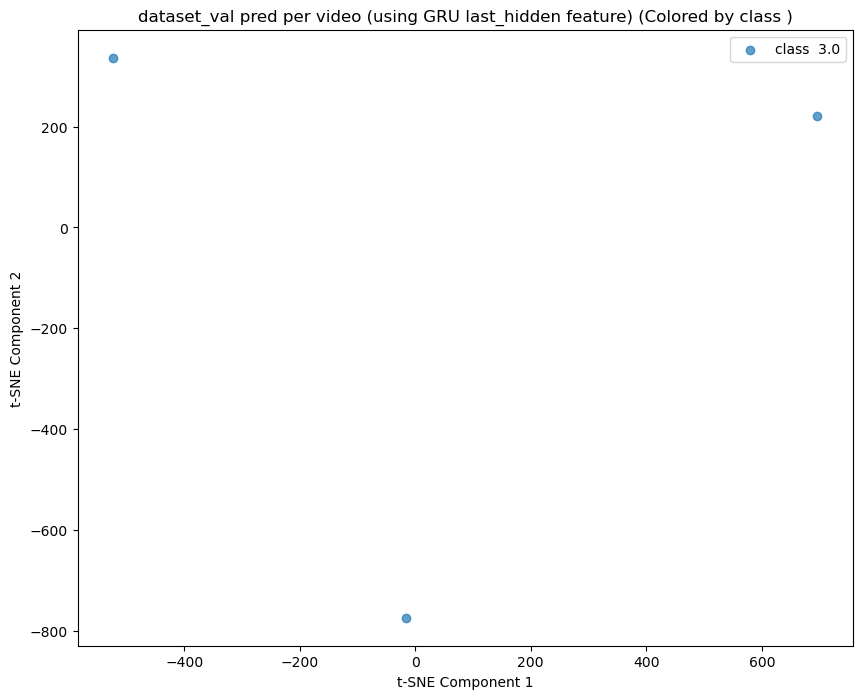

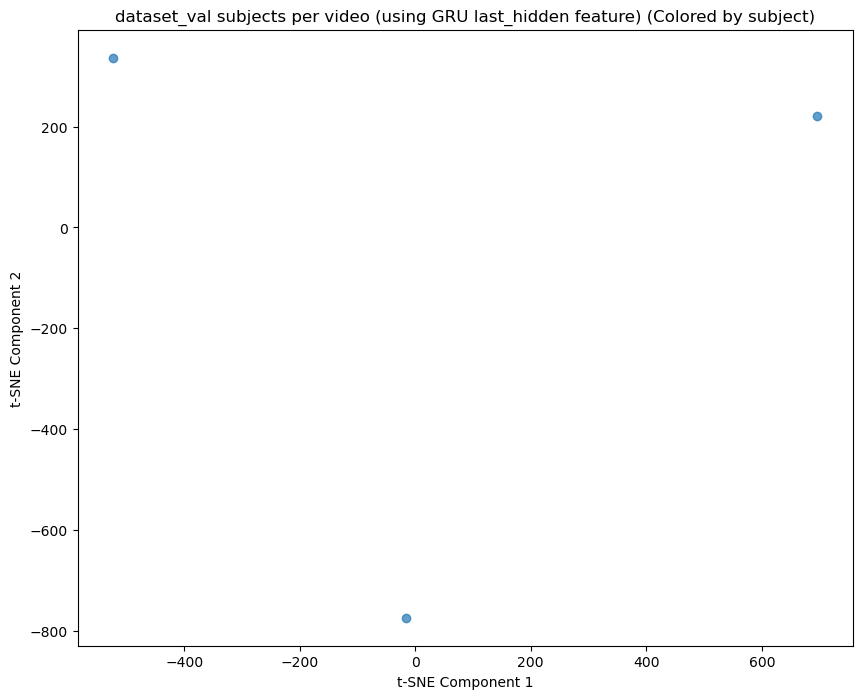

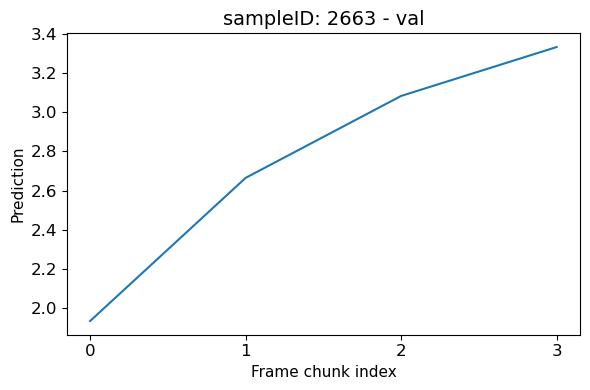

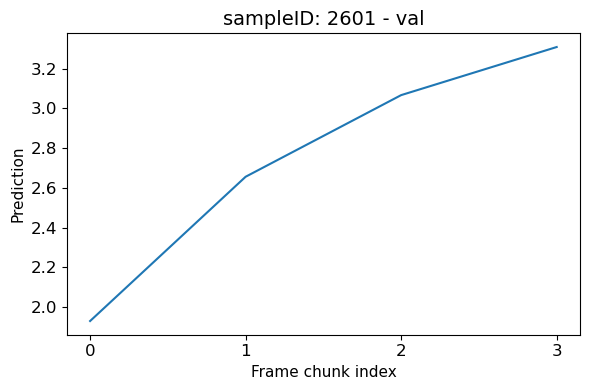

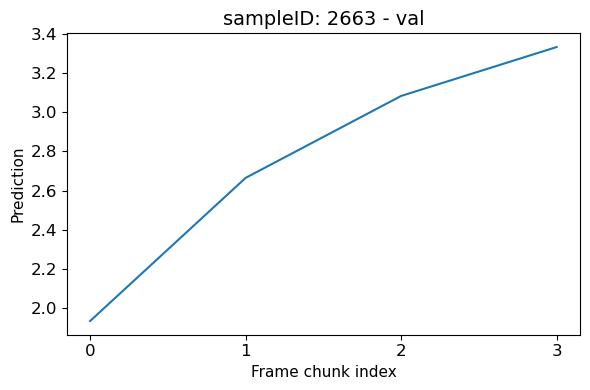

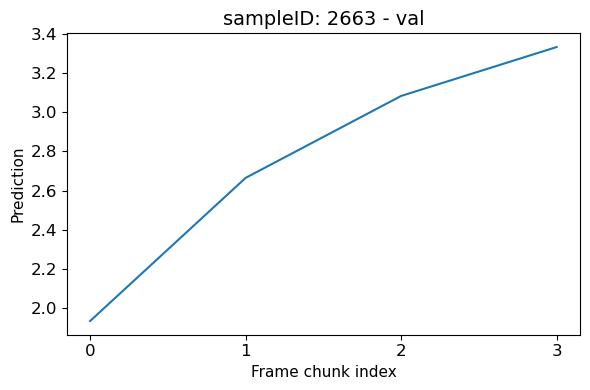

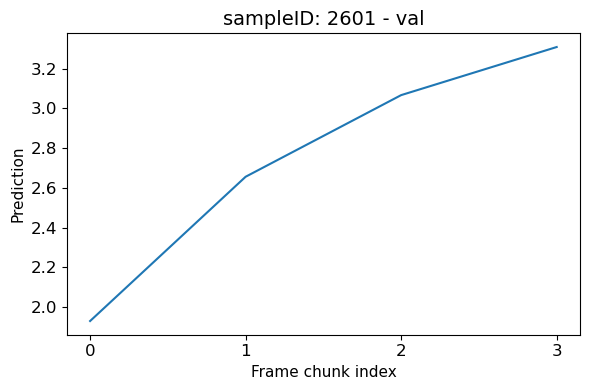

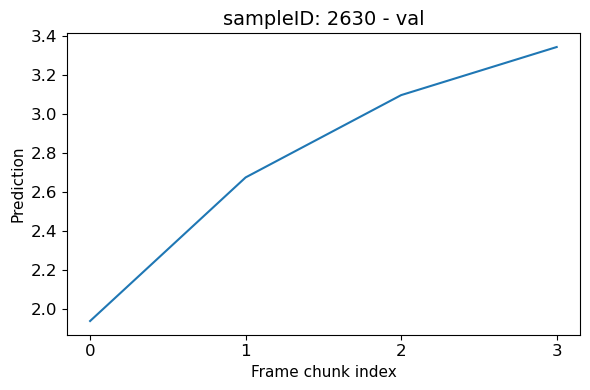

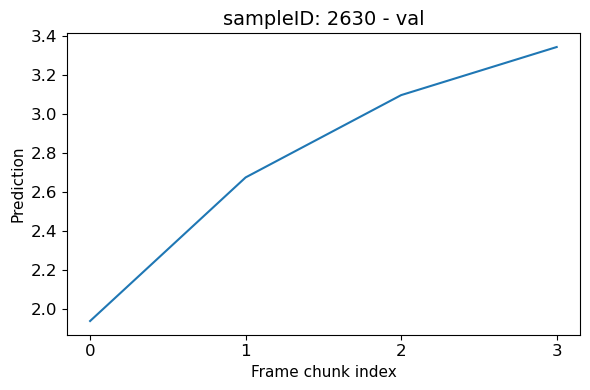

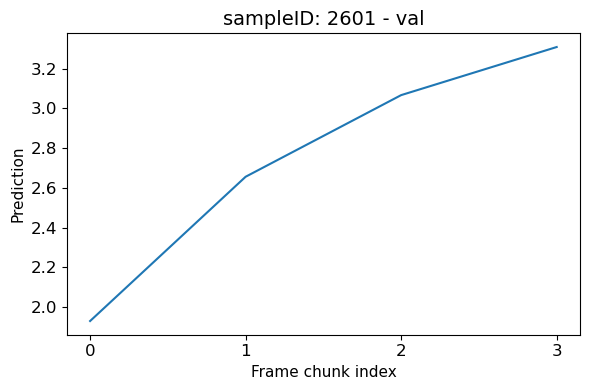

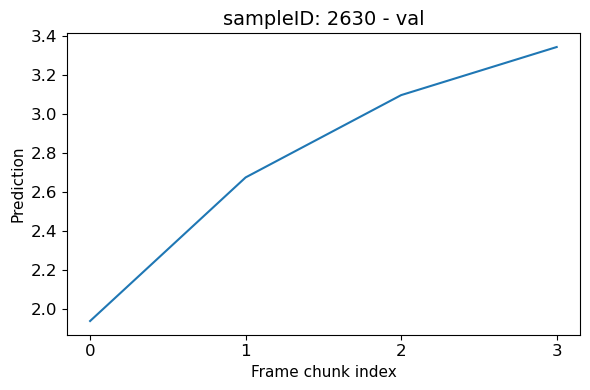

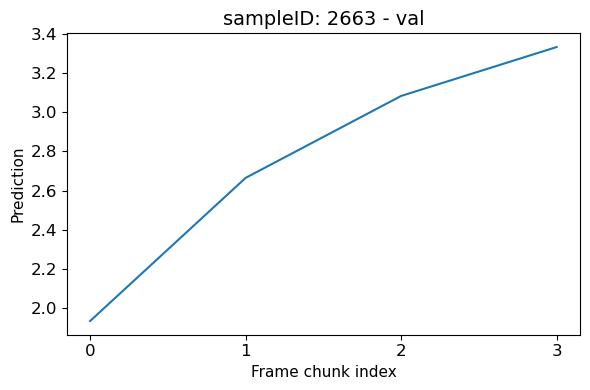

In [1]:
%load_ext autoreload
%autoreload 2
from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY, HEAD
import os
from custom.model import Model_Advanced
from transformers import AutoImageProcessor
from custom.head import HeadSVR, HeadGRU
import time
import torch.nn as nn
import torch.optim as optim
import custom.scripts as scripts

model_type = MODEL_TYPE.VIDEOMAE_v2_S
pooling_embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL
pooling_clips_reduction = CLIPS_REDUCTION.NONE
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW
# path_dict ={
#   'all' : os.path.join('partA','starting_point','samples.csv'),
  # 'train' : os.path.join('partA','starting_point','train_21.csv'),
  # 'val' : os.path.join('partA','starting_point','val_26.csv'),
  # 'test' : os.path.join('partA','starting_point','test_5.csv')
# }
path_dataset = os.path.join('partA','video','video')  
path_cvs_dataset = os.path.join('partA','starting_point','test_23.csv')
head = HEAD.GRU
# if head == 'GRU':
params = {
  'hidden_size': 512,
  'num_layers': 2,
  'dropout': 0.3,
  'input_size': 384 * 8 # can be 384  (small), 768  (base), 1408  (large) [temporal_dim considered as input sequence for GRU]
                    # can be 384*8(small), 768*8(base), 1408*8(large) [temporal_dim considered feature in GRU] 
}

preprocess = AutoImageProcessor.from_pretrained(os.path.join("local_model_directory","preprocessor_config.json"))
stride_window_in_video = 40
model_advanced = scripts.run_train_test(model_type=model_type, 
                      pooling_embedding_reduction=pooling_embedding_reduction, 
                      pooling_clips_reduction=pooling_clips_reduction, 
                      sample_frame_strategy=sample_frame_strategy, 
                      path_csv_dataset=path_cvs_dataset, 
                      path_video_dataset=path_dataset,
                      head=head,
                      stride_window_in_video=stride_window_in_video, 
                      head_params=params,
                      preprocess=preprocess,
                      k_fold = 1,
                      epochs = 5,
                      train_size=0.8,
                      test_size=0.1,
                      val_size=0.1,
                      batch_size_training=2,
                      batch_size_feat_extraction=2,  
                      criterion = nn.L1Loss(),
                      optimizer_fn = optim.Adam,
                      lr = 0.001,
                      random_state_split_dataset=42,
                      is_save_features_extracted=False, 
                      is_validation=True,
                      is_plot_dataset_distribution=True,
                      is_plot_loss=True,
                      is_plot_tsne_backbone_feats=True,
                      is_plot_tsne_head_pred=True,
                      is_plot_tsne_gru_feats=True,
                      is_create_video_prediction=True,
                      is_create_video_prediction_per_video=True,
                      is_round_output_loss=False,
                      is_shuffle_training_batch=True,
                      is_shuffle_video_chunks=True,
                      is_download_if_unavailable=False
                      )

In [10]:
del model_advanced

In [11]:
%autoreload 2
import custom.scripts as scripts

model_advanced.dataset.stride_window = 40
scripts.predict_per_video(
    path_csv='partA/starting_point/samples.csv',
    sample_ids=[10,35],
    model_advanced=model_advanced,
    root_folder_path='history_run/VIDEOMAE_v2_B_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733007378/train_GRU/video',
)

NameError: name 'model_advanced' is not defined

In [16]:
import os

def set_working_directory():
  target_dir = 'PainAssessmentVideo'
  current_dir = os.getcwd()
  if os.path.split(current_dir)[-1] != target_dir:
    while os.path.split(current_dir)[-1] != target_dir:
      current_dir = os.path.dirname(current_dir)
      if current_dir == os.path.dirname(current_dir):  # reached the root directory
        raise FileNotFoundError(f"{target_dir} not found in the directory tree. Please set PainAssessmentVideo as current working directory.")
    os.chdir(current_dir)
  print(f"Current working directory set to: {os.getcwd()}")

def create_folder(path):
  if not os.path.exists(path):
    os.makedirs(path)
    print(f'Folder created: {path}')
  else:
    print(f'Folder already exists: {path}')                                                                                       